## 1. **Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from ydata_profiling import ProfileReport
from pathlib import Path
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

## 2. **Get Data**

### 2.1. **Load datasets**

In [2]:
# Load application record and credit record data into DataFrames
cc_application_df = pd.read_csv('data/application_record.csv')
cc_status_df = pd.read_csv('data/credit_record.csv')

### 2.2. **Create target variable**

In [3]:
# Determine how long each person has held their credit card
cc_duration = cc_status_df.groupby("ID")["MONTHS_BALANCE"].min().reset_index().rename(columns={"MONTHS_BALANCE": "account_age_(months)"})
cc_application_df = pd.merge(cc_application_df, cc_duration, how="left", on="ID")

# Create a new column 'is_risky' that identifies if the STATUS is considered risky (values 2, 3, 4, or 5)
cc_status_df['is_risky'] = np.where(cc_status_df['STATUS'].isin(['2', '3', '4', '5']), 'Yes', 'No')

# Determine if a person has ever defaulted, with Yes mapped to 1 and No mapped to 0
cc_defaulter = cc_status_df.groupby('ID')['is_risky'].max().reset_index()
cc_defaulter['is_risky'] = cc_defaulter['is_risky'].map({'Yes': 1, 'No': 0})
cc_application_df = pd.merge(cc_application_df, cc_defaulter, how='inner', on='ID')

# Ensure duration is positive and convert it to integer type for consistent data handling
cc_application_df['account_age_(months)'] = np.abs(cc_application_df['account_age_(months)']).astype('int64')

### 2.3. **Rename features**

In [4]:
# Define a mapping to rename DataFrame columns for clarity and consistency
column_rename_map = {
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'owns_car',
    'FLAG_OWN_REALTY': 'owns_property',
    'CNT_CHILDREN': 'child_count',
    'AMT_INCOME_TOTAL': 'annual_income',
    'NAME_INCOME_TYPE': 'occupation',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'marital_status',
    'NAME_HOUSING_TYPE': 'accommodation',
    'DAYS_BIRTH': 'days_lived',
    'DAYS_EMPLOYED': 'employment_duration',
    'FLAG_MOBIL': 'has_mobile',
    'FLAG_WORK_PHONE': 'has_work_phone',
    'FLAG_PHONE': 'has_phone',
    'FLAG_EMAIL': 'has_email',
    'OCCUPATION_TYPE': 'job_title',
    'CNT_FAM_MEMBERS': 'family_size'
}
cc_application_df.rename(columns=column_rename_map, inplace=True)

### 2.4. **Split data**

In [5]:
# Split the data into train and test sets
def data_split(df, size):
    train_df, test_df = train_test_split(df, test_size=size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

cc_train_original, cc_test_original = data_split(cc_application_df, 0.2)

In [6]:
# Create a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

## 3. **Explore the Data**

### 3.1. **Pandas Profiling**

In [7]:
profile_report = ProfileReport(cc_train_copy, explorative=True)
profile_report_file_path = Path('pandas_profiling_report.html')

# Checking if the pandas profile report file exists in the current directory
try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("pandas_profiling_report.html")

### 3.2. **Initial Data Overview**

In [8]:
cc_application_df.head()

,ID,gender,owns_car,owns_property,child_count,annual_income,occupation,education,marital_status,accommodation,days_lived,employment_duration,has_mobile,has_work_phone,has_phone,has_email,job_title,family_size,account_age_(months),is_risky
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,0
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,20,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,5,0


In [9]:
cc_application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    9709 non-null   int64  
 1   gender                9709 non-null   object 
 2   owns_car              9709 non-null   object 
 3   owns_property         9709 non-null   object 
 4   child_count           9709 non-null   int64  
 5   annual_income         9709 non-null   float64
 6   occupation            9709 non-null   object 
 7   education             9709 non-null   object 
 8   marital_status        9709 non-null   object 
 9   accommodation         9709 non-null   object 
 10  days_lived            9709 non-null   int64  
 11  employment_duration   9709 non-null   int64  
 12  has_mobile            9709 non-null   int64  
 13  has_work_phone        9709 non-null   int64  
 14  has_phone             9709 non-null   int64  
 15  has_email            

In [10]:
cc_application_df.describe()

,ID,child_count,annual_income,days_lived,employment_duration,has_mobile,has_work_phone,has_phone,has_email,family_size,account_age_(months),is_risky
count,9.709000e+03,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.0,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000
mean,5.076105e+06,0.422804,1.812282e+05,-15991.811618,61732.846328,1.0,0.217427,0.287671,0.087548,2.182614,27.270059,0.021217
std,4.080270e+04,0.767019,9.927731e+04,4246.224468,139656.322958,0.0,0.412517,0.452700,0.282650,0.932918,16.648057,0.144116
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.036955e+06,0.000000,1.125000e+05,-19565.000000,-2995.000000,1.0,0.000000,0.000000,0.000000,2.000000,13.000000,0.000000
50%,5.069449e+06,0.000000,1.575000e+05,-15611.000000,-1374.000000,1.0,0.000000,0.000000,0.000000,2.000000,26.000000,0.000000
75%,5.112986e+06,1.000000,2.250000e+05,-12440.000000,-339.000000,1.0,0.000000,1.000000,0.000000,3.000000,41.000000,0.000000
max,5.150479e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000,1.000000


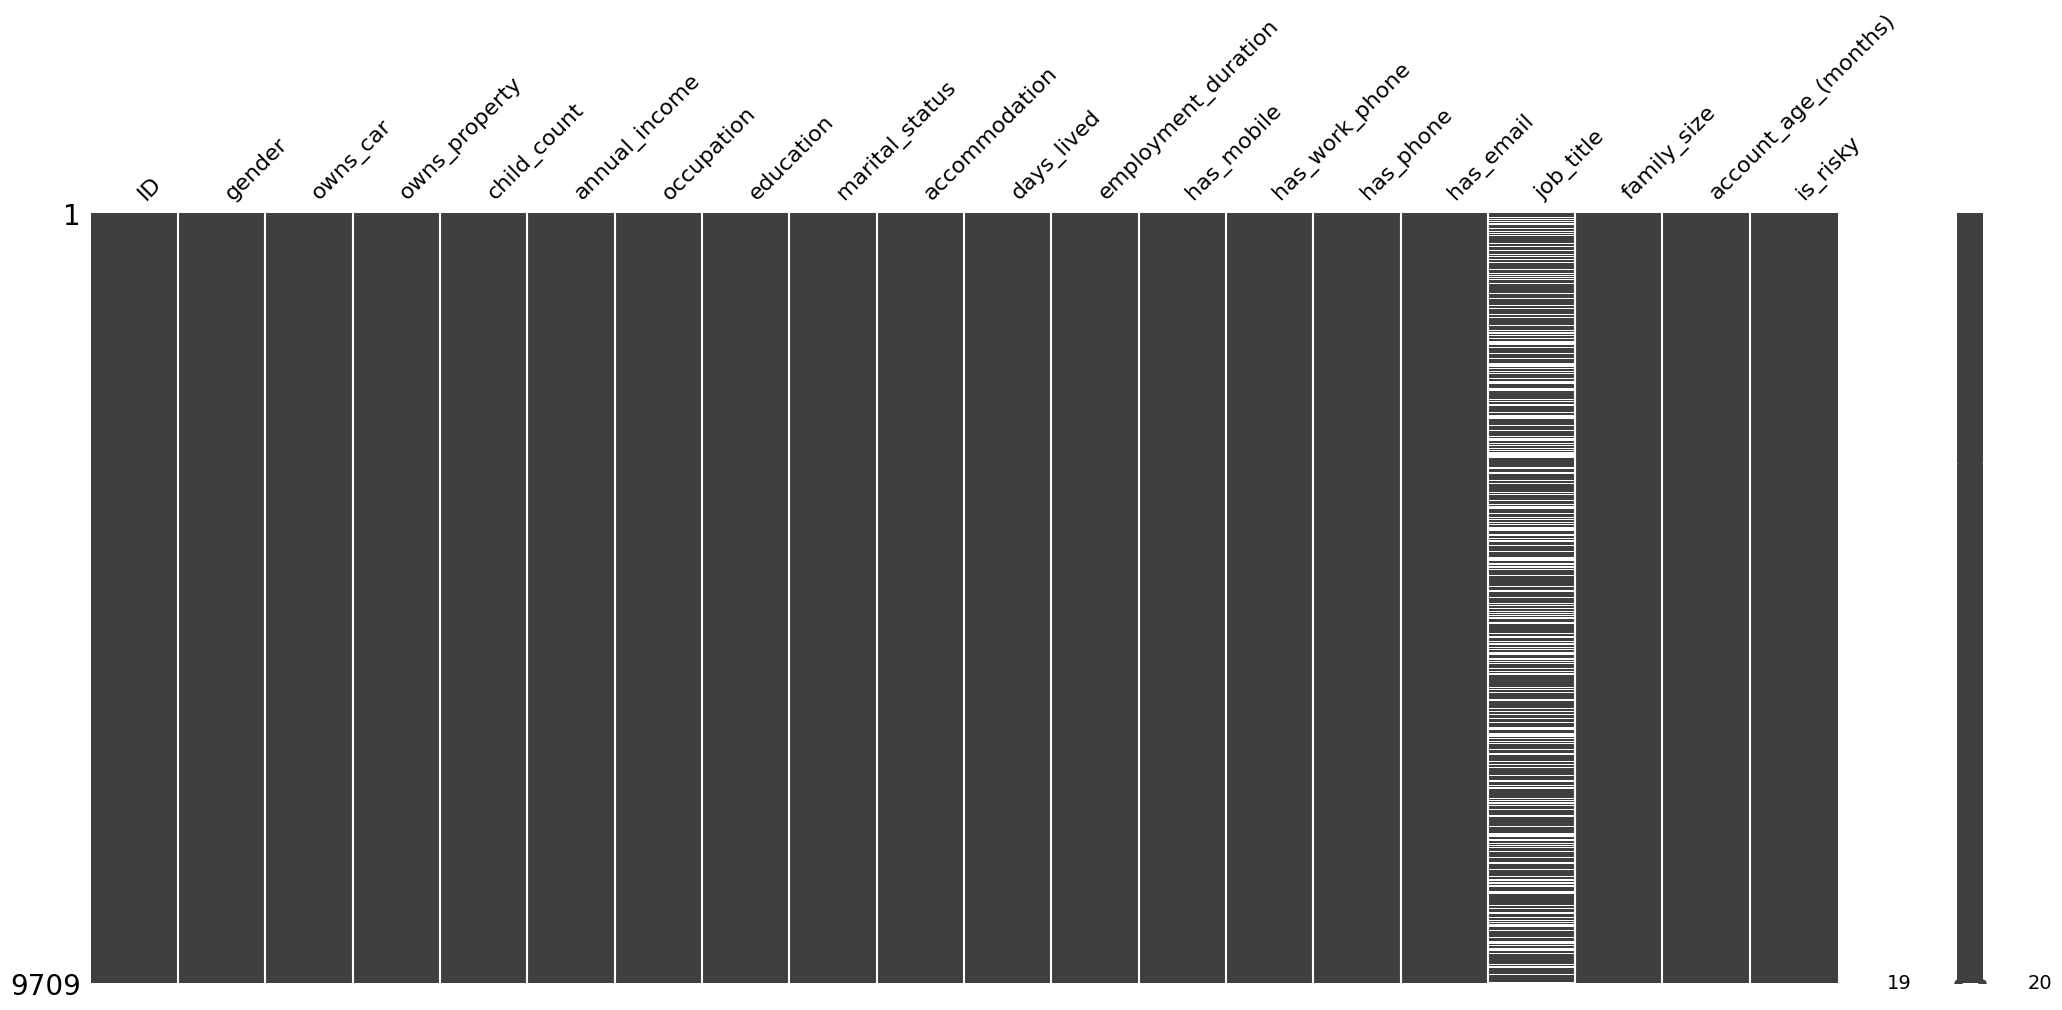

In [11]:
msno.matrix(cc_application_df)
plt.show()

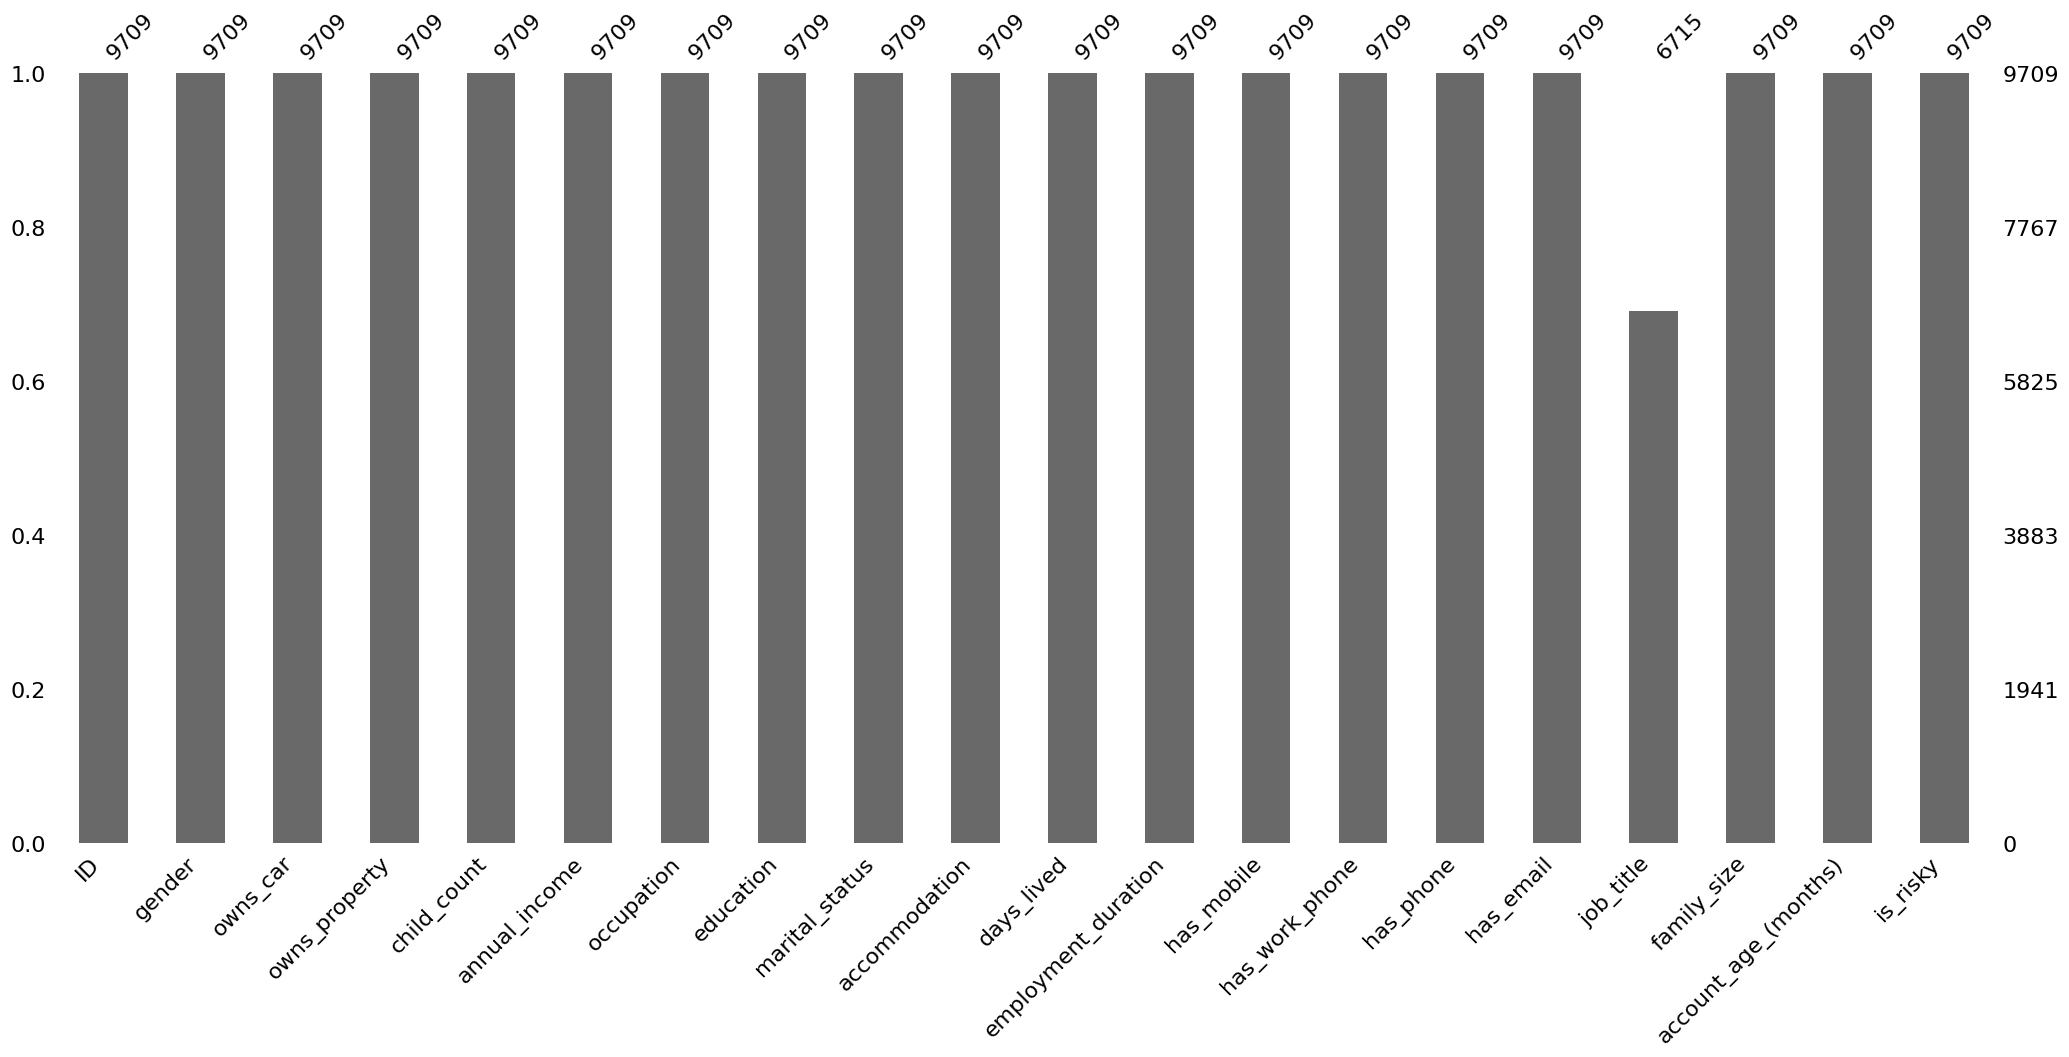

In [12]:
msno.bar(cc_application_df)
plt.show()

### 3.3. **Custom Functions for Feature Exploration**

In [13]:
#Function that will return the count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [14]:
# Function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case 'days_lived':
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))

        case 'annual_income':
            pd.set_option('display.float_format', lambda x: '%.2f' % x)
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))

        case 'employment_duration':
            employed_non_retired = df[feature][df[feature] < 0]
            non_retired_years = np.abs(employed_non_retired) / 365.25
            print('Description (Years):\n{}'.format((non_retired_years).describe()))
            print('*'*50)
            print('Data type:{}'.format(df[feature].dtype))

        case 'account_age_(months)':
            pd.set_option('display.float_format', lambda x: '%.2f' % x)
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))

        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('{}'.format(value_cnt))

In [15]:
# Function to create a bar chart plot
def create_bar_plot(df, feature):
    value_counts = df[feature].value_counts()
    
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.xlabel(f"{feature.replace('_', ' ').title()}", )
    plt.xticks(rotation=90)        
    plt.ylabel("Count")
    plt.title("Bar Chart")
    plt.show()

In [16]:
# Function to create a pie chart plot
def create_pie_plot(df, feature):
    value_counts = df[feature].value_counts(normalize=True) * 100
    
    match feature:                
        case 'accommodation':
            explode = [0, 0.05, 0.15, 0.3, 0.5, 0.7]
            colors = sns.color_palette('Set3')
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=270, explode=explode, colors=colors)
        
        case 'education':
            explode = [0, 0.05, 0.15, 0.3, 0.5]
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=45, explode=explode)

        case _:
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.2f%%')
        
    plt.title("Pie Chart")
    plt.show()

In [17]:
# Function to create a histogram plot
def create_hist_plot(df, feature):
    match feature:
        case 'days_lived':
            sns.histplot(np.abs(df[feature]) / 365.25, bins=50, kde=True)
            plt.xlabel('Age (Years)')
        
        case 'annual_income':
            income_formatter = lambda x, _: f'{int(x / 100000)}'
            sns.histplot(df[feature], bins=50, kde=True)
            plt.gca().get_xaxis().set_major_formatter(mtick.FuncFormatter(income_formatter))
            plt.xlabel('Annual Income (Lakh)')
        
        case 'employment_duration':
            employed_non_retired = df[feature][df[feature] < 0]
            non_retired_years = np.abs(employed_non_retired) / 365.25
            sns.histplot(non_retired_years, bins=50, kde=True)
            plt.xlabel("Employment Duration (Years)")

        case _:
            sns.histplot(df[feature], bins=50, kde=True)
            plt.xlabel(feature.replace('_', ' ').title())
            
    plt.title("Histogram")
    plt.ylabel("Count")
    plt.show()

In [18]:
# Function to create a Boxplot
def create_boxplot(df, feature):
    match feature:
        case 'days_lived':
            sns.boxplot(y=np.abs(df[feature]) / 365.25)
            plt.ylabel('Age (Years)')

        case 'annual_income':
            income_formatter = lambda x, _: f'{int(x / 100000)}'
            ax = sns.boxplot(y=df[feature])
            ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(income_formatter))
            plt.ylabel('Annual Income (Lakh)')

        case 'employment_duration':
            employed_non_retired = df[feature][df[feature] < 0]
            non_retired_years = np.abs(employed_non_retired) / 365.25
            sns.boxplot(y=non_retired_years)
            plt.ylabel("Employment Duration (Years)")

        case _:
            sns.boxplot(y=df[feature])
            plt.ylabel(feature.replace("_", " ").title())
    
    plt.title("Box Plot")
    plt.show()

In [19]:
# Function to create a Low/High Risk Boxplot
def low_high_risk_boxplot(df, feature):
    match feature:
        case 'days_lived':
            df['Age (Years)'] = np.abs(df[feature]) / 365.25
            sns.boxplot(x=df['is_risky'], y=df['Age (Years)'])
            plt.ylabel('Age (Years)')
        
        case 'annual_income':
            ax = sns.boxplot(x=df['is_risky'], y=df[feature])
            ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x / 100000)}'))
            plt.ylabel('Annual Income (Lakh)')

        case 'employment_duration':
            employed_non_retired = df[feature][df[feature] < 0]
            non_retired_years = np.abs(employed_non_retired) / 365.25
            sns.boxplot(x=df['is_risky'], y=non_retired_years)
            plt.ylabel("Employment Duration (Years)")
            
        case _:
            sns.boxplot(x=df['is_risky'], y=df[feature])
            plt.ylabel(feature.replace("_", " ").title())
                
    plt.title("Low & High Risk Individuals - Box Plot")
    plt.xlabel('Risk')
    plt.xticks(ticks=[0, 1], labels=["Low", "High"])
    plt.show()

In [20]:
# Function to create a Low/High Risk Barplot
def low_high_risk_barplot(df, feature):
    aggregated_data = df.groupby(feature)['is_risky'].sum().sort_values(ascending=False)
    sns.barplot(x=aggregated_data.index, y=aggregated_data.values)
    plt.title("Low & High Risk Individuals - Bar Chart")
    plt.xlabel(feature.replace("_", " ").title())
    plt.xticks(rotation=90)        
    plt.ylabel('Count')
    plt.show()

### 3.4. **Univariate Analysis**

#### 3.4.1. **Gender**

In [21]:
gen_info_feat(cc_train_copy, 'gender')

Description:
count     7767
unique       2
top          F
freq      5029
Name: gender, dtype: object
**************************************************
Data type: object
**************************************************
        Count  Frequency (%)
gender                      
F        5029      64.748294
M        2738      35.251706


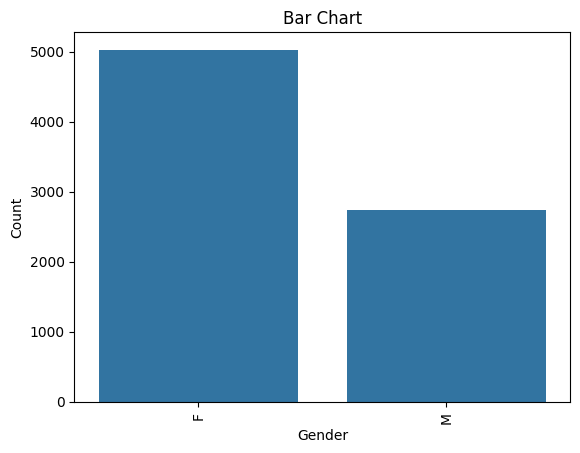

In [22]:
create_bar_plot(cc_train_copy, 'gender')

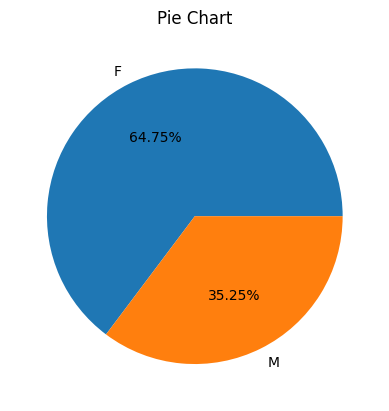

In [23]:
create_pie_plot(cc_train_copy, 'gender')

**Interpretation:**  
- The data reveals a higher proportion of female applicants compared to male applicants, with 65% of the total being female and 35% being male.

#### 3.4.2. **Age**

In [24]:
gen_info_feat(cc_train_copy, 'days_lived')

Description:
count    7767.000000
mean       43.822532
std        11.593486
min        21.095140
25%        34.083504
50%        42.787132
75%        53.564682
max        68.862423
Name: days_lived, dtype: float64
**************************************************
Data type: int64


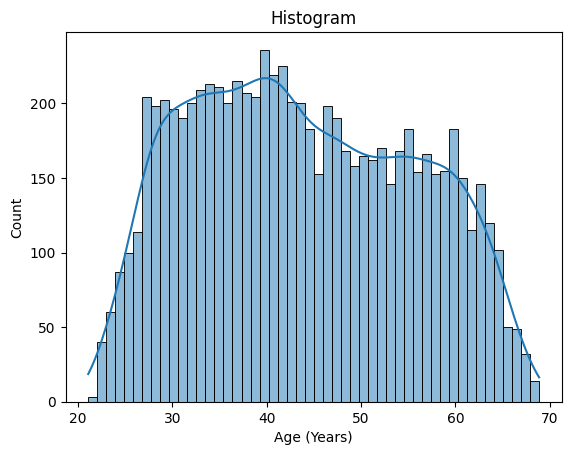

In [25]:
create_hist_plot(cc_train_copy, 'days_lived')

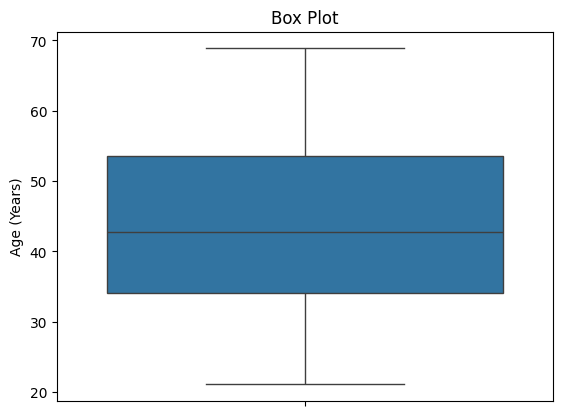

In [26]:
create_boxplot(cc_train_copy, 'days_lived')

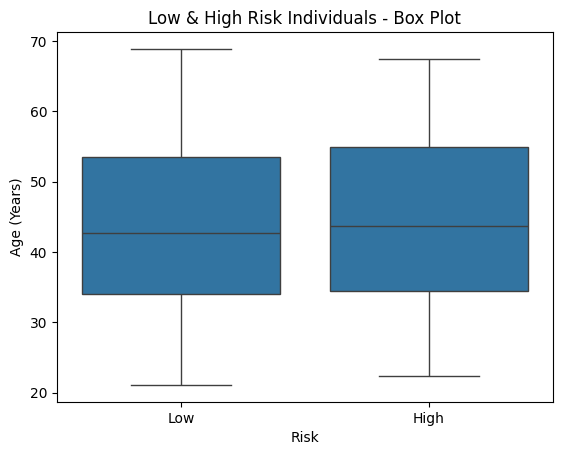

In [27]:
low_high_risk_boxplot(cc_train_copy, 'days_lived')

**Interpretation:**  
- The youngest applicant is 21 years old, while the oldest is 68 years old. The average age of applicants is 43.8 years, with a median age of 42.7 years, highlighting an outlier-insensitive central tendency.  
- The distribution of the age feature is slightly positively skewed, indicating a larger number of applicants in younger age groups.  
- There is no observed difference in the average age of high-risk and low-risk applicants, suggesting that age may not play a significant role in risk classification.

**Note:** This analysis might not be fully accurate due to potential imbalance in the target variable, which could affect the reliability of the conclusions.

#### 3.4.3. **Marital Status**

In [28]:
gen_info_feat(cc_train_copy, 'marital_status')

Description:
count        7767
unique          5
top       Married
freq         5227
Name: marital_status, dtype: object
**************************************************
Data type: object
**************************************************
                      Count  Frequency (%)
marital_status                            
Married                5227      67.297541
Single / not married   1088      14.007982
Civil marriage          666       8.574739
Separated               457       5.883868
Widow                   329       4.235870


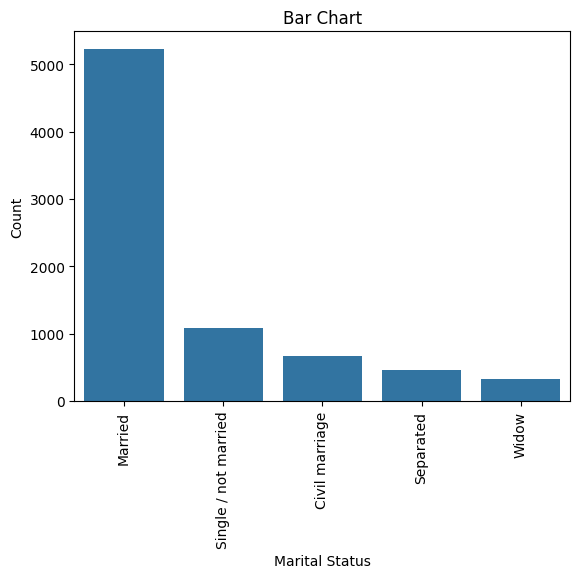

In [29]:
create_bar_plot(cc_train_copy, 'marital_status')

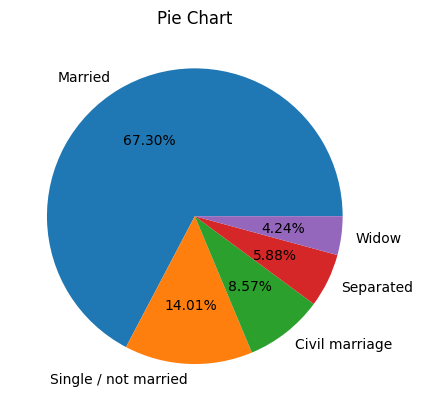

In [30]:
create_pie_plot(cc_train_copy, 'marital_status')

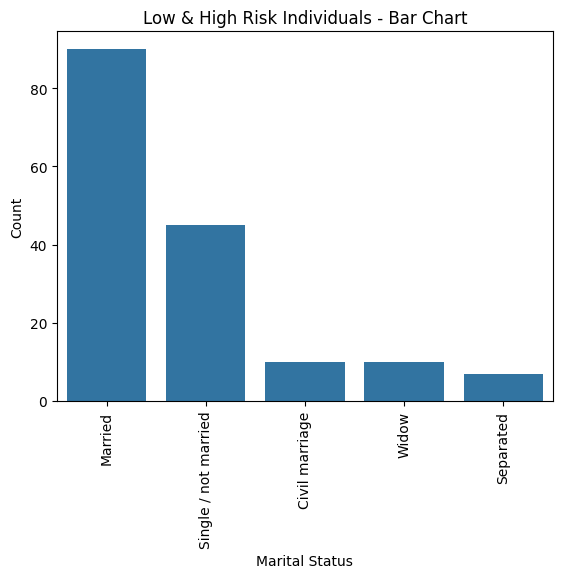

In [31]:
low_high_risk_barplot(cc_train_copy, 'marital_status')

**Interpretation:**
- The majority of applicants are married.
- While widowed applicants are fewer in number overall compared to separated applicants, the proportion of high-risk individuals among widows appears higher, suggesting that widowed applicants might have a relatively higher risk factor than separated ones.

#### 3.4.4. **Family Size**

In [32]:
gen_info_feat(cc_train_copy, 'family_size')

Description:
count    7767.000000
mean        2.184241
std         0.942279
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: family_size, dtype: float64
**************************************************
Data type: float64
**************************************************
             Count  Frequency (%)
family_size                      
2.0           4147      53.392558
1.0           1559      20.072100
3.0           1297      16.698854
4.0            650       8.368740
5.0             93       1.197374
6.0             14       0.180250
7.0              4       0.051500
15.0             1       0.012875
9.0              1       0.012875
20.0             1       0.012875


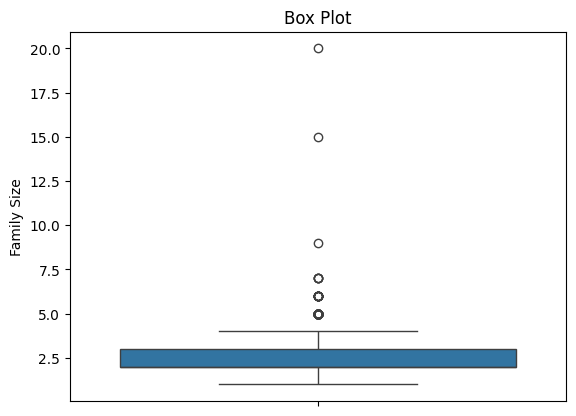

In [33]:
create_boxplot(cc_train_copy, 'family_size')

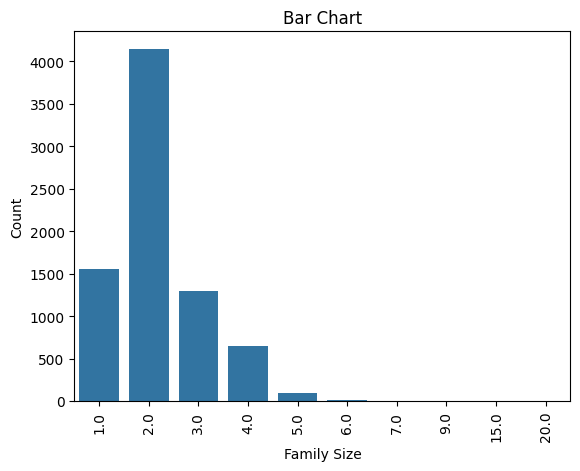

In [34]:
create_bar_plot(cc_train_copy, 'family_size')

**Interpretation:**  
- Most applicants come from households with two members, a trend further supported by the fact that most applicants do not have children (which will be discussed in further detail).  
- There are 6 outliers in the dataset, with two of them being particularly extreme, having 20 and 15 members in their households.

#### 3.4.5. **Children Count**

In [35]:
gen_info_feat(cc_train_copy, 'child_count')

Description:
count    7767.000000
mean        0.423716
std         0.778985
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        19.000000
Name: child_count, dtype: float64
**************************************************
Data type: int64
**************************************************
             Count  Frequency (%)
child_count                      
0             5466      70.374662
1             1488      19.157976
2              691       8.896614
3              100       1.287498
4               14       0.180250
5                5       0.064375
14               1       0.012875
7                1       0.012875
19               1       0.012875


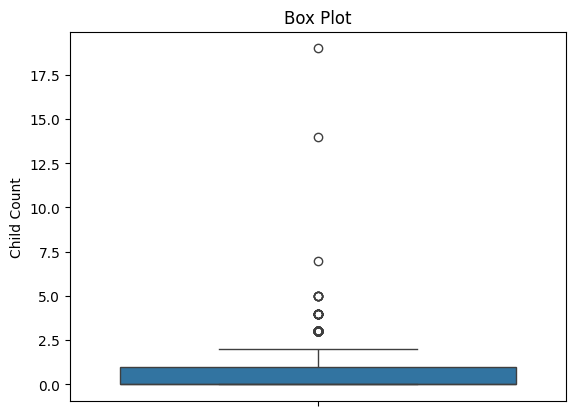

In [36]:
create_boxplot(cc_train_copy, 'child_count')

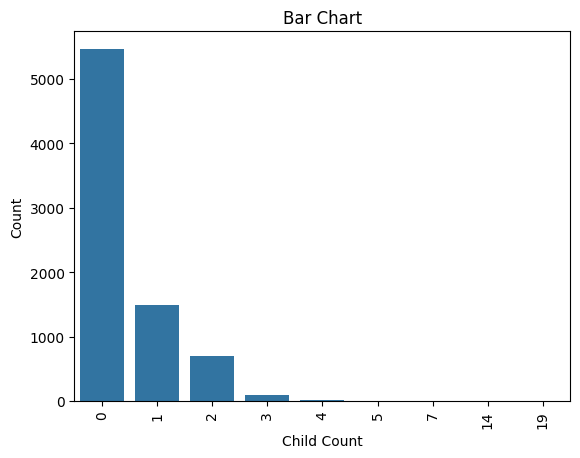

In [37]:
create_bar_plot(cc_train_copy, 'child_count')

**Interpretation:**  
- As previously discussed, the majority of applicants do not have children, aligning with the overall trend observed in the data.  
- Additionally, there are 6 outliers in the dataset, which are likely the same outliers identified in the family member count, indicating possible data anomalies or exceptional cases.

#### 3.4.6. **Accommodation**

In [38]:
gen_info_feat(cc_train_copy, 'accommodation')

Description:
count                  7767
unique                    6
top       House / apartment
freq                   6939
Name: accommodation, dtype: object
**************************************************
Data type: object
**************************************************
                     Count  Frequency (%)
accommodation                            
House / apartment     6939      89.339513
With parents           357       4.596369
Municipal apartment    271       3.489121
Rented apartment       113       1.454873
Office apartment        64       0.823999
Co-op apartment         23       0.296125


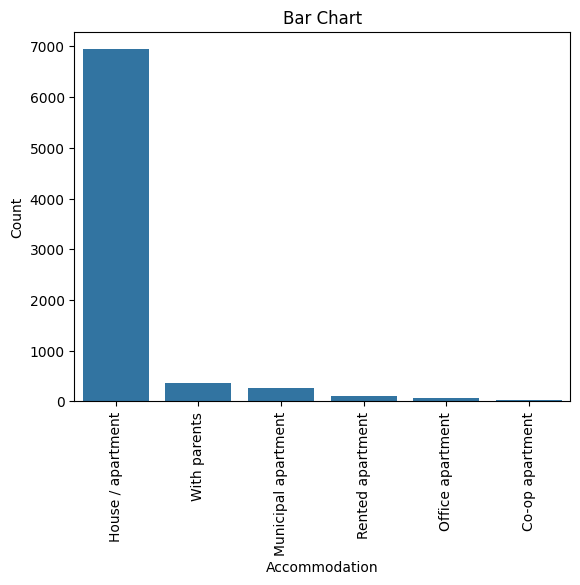

In [39]:
create_bar_plot(cc_train_copy, 'accommodation')

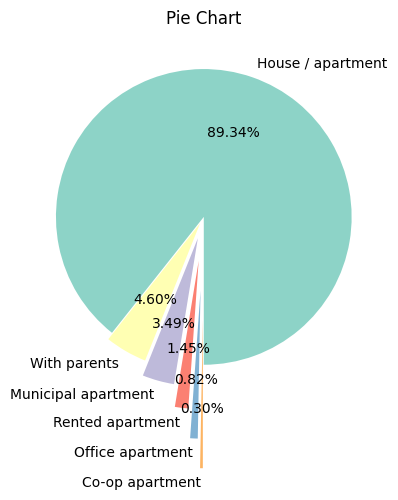

In [40]:
create_pie_plot(cc_train_copy, 'accommodation')

**Interpretation:**  
- Almost all applicants live in a house or apartment, with very few reporting different housing situations.

#### 3.4.7. **Annual Income**

In [41]:
gen_info_feat(cc_train_copy, 'annual_income')

Description:
count      7767.00
mean     181047.38
std       98773.14
min       27000.00
25%      112500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: annual_income, dtype: float64
**************************************************
Data type: float64


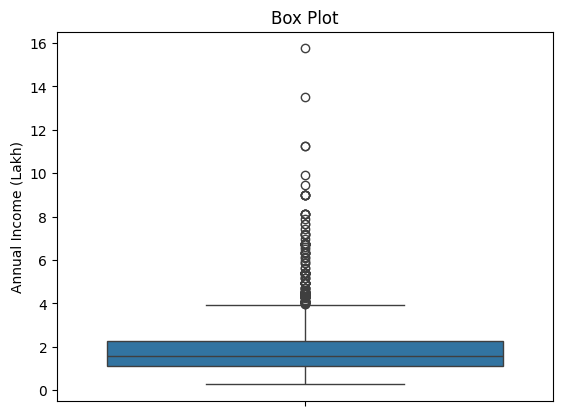

In [42]:
create_boxplot(cc_train_copy, 'annual_income')

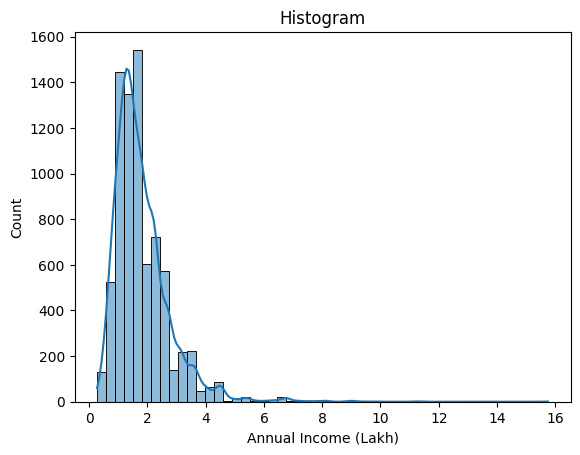

In [43]:
create_hist_plot(cc_train_copy, 'annual_income')

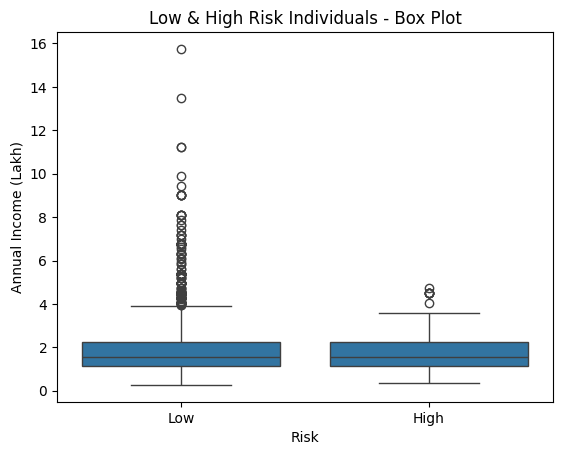

In [44]:
low_high_risk_boxplot(cc_train_copy, 'annual_income')

**Interpretation:**  
- The average annual income of applicants is ₹181,047.38, though this figure is influenced by outliers. Excluding the outliers, most applicants earn around ₹157,500.  
- There are three applicants with incomes exceeding ₹1,000,000.  
- The distribution of the annual income feature is positively skewed, indicating that there are a few individuals with significantly higher incomes compared to the majority.  
- There is no significant difference between the average annual incomes of high-risk and low-risk applicants, suggesting that income does not have a strong impact on risk classification.

**Note:** This analysis might not be fully accurate due to potential imbalance in the target variable, which could affect the reliability of the conclusions.

#### 3.4.8. **Job title**

In [45]:
gen_info_feat(cc_train_copy, 'job_title')

Description:
count         5384
unique          18
top       Laborers
freq          1379
Name: job_title, dtype: object
**************************************************
Data type: object
**************************************************
                       Count  Frequency (%)
job_title                                  
Laborers                1379          25.61
Sales staff              767          14.25
Core staff               701          13.02
Managers                 632          11.74
Drivers                  506           9.40
High skill tech staff    301           5.59
Accountants              233           4.33
Medicine staff           233           4.33
Security staff           147           2.73
Cooking staff            146           2.71
Cleaning staff           115           2.14
Private service staff     68           1.26
Low-skill Laborers        43           0.80
Secretaries               35           0.65
Waiters/barmen staff      31           0.58
HR staff    

In [46]:
missing_percentage = cc_train_copy['job_title'].isna().mean() * 100

print(f'The percentage of missing rows in "Job Title" is {missing_percentage:.2f} %')

The percentage of missing rows in "Job Title" is 30.68 %


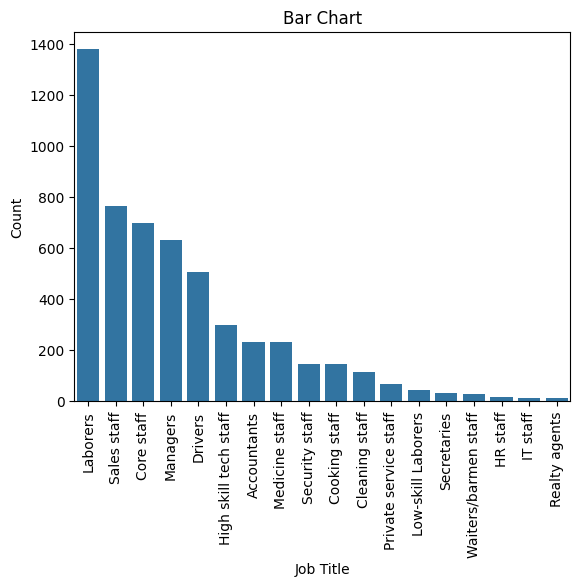

In [47]:
create_bar_plot(cc_train_copy, 'job_title')

**Interpretation:**  
- The most common job title among applicants is "laborers," with a significantly higher frequency compared to other titles.  
- There is 30.68% missing data in the job title feature, which could impact the analysis and the conclusions drawn from this variable.

#### 3.4.9. **Occupation**

In [48]:
gen_info_feat(cc_train_copy, 'occupation')

Description:
count        7767
unique          5
top       Working
freq         3947
Name: occupation, dtype: object
**************************************************
Data type: object
**************************************************
                      Count  Frequency (%)
occupation                                
Working                3947          50.82
Commercial associate   1847          23.78
Pensioner              1382          17.79
State servant           589           7.58
Student                   2           0.03


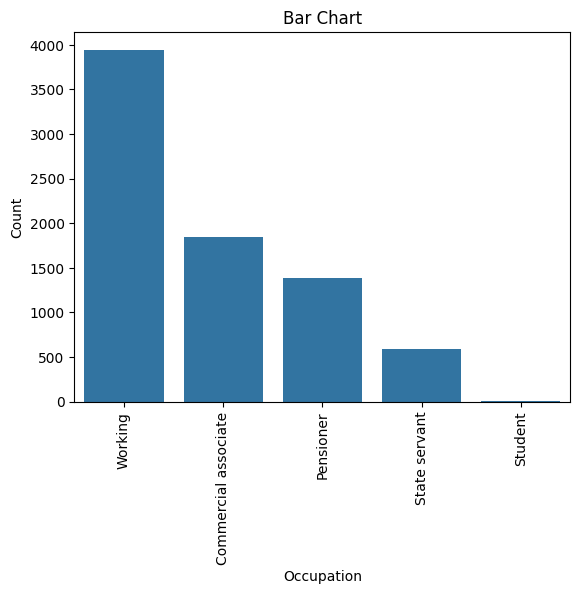

In [49]:
create_bar_plot(cc_train_copy, 'occupation')

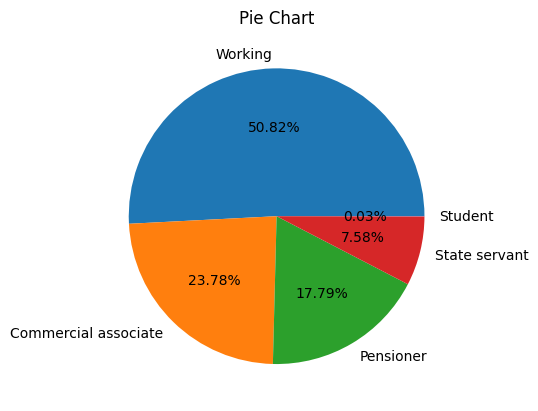

In [50]:
create_pie_plot(cc_train_copy, 'occupation')

**Interpretation**
- A majority of the applicants are employed, indicating that most individuals seeking credit are currently working.
- This suggests a relatively stable financial background for many applicants, which might influence the decision-making process for credit approval.

#### 3.4.10. **Education**

In [51]:
gen_info_feat(cc_train_copy, 'education')

Description:
count                              7767
unique                                5
top       Secondary / secondary special
freq                               5400
Name: education, dtype: object
**************************************************
Data type: object
**************************************************
                               Count  Frequency (%)
education                                          
Secondary / secondary special   5400          69.52
Higher education                1969          25.35
Incomplete higher                297           3.82
Lower secondary                   95           1.22
Academic degree                    6           0.08


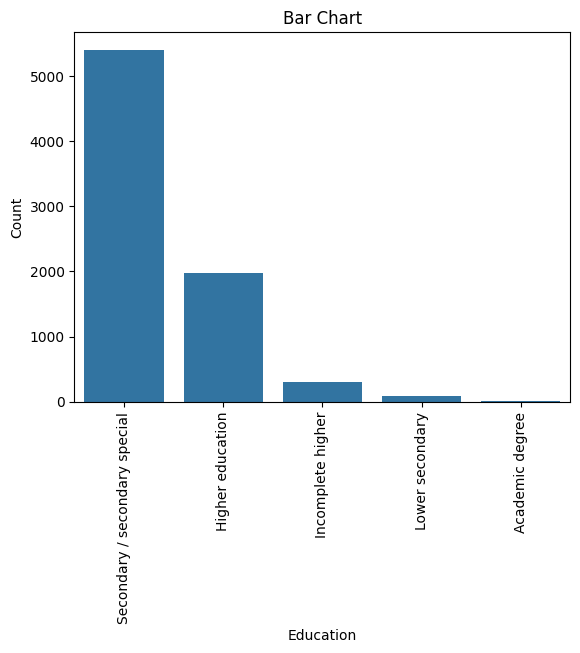

In [52]:
create_bar_plot(cc_train_copy, 'education')

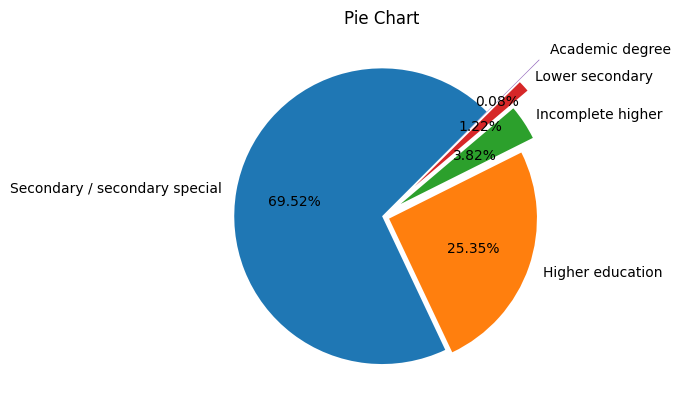

In [53]:
create_pie_plot(cc_train_copy, 'education')

**Interpretation**
- A significant portion of applicants have completed their secondary education, while approximately a quarter have pursued higher education.

#### 3.4.11. **Employment Duration (Years)**

In [54]:
gen_info_feat(cc_train_copy, 'employment_duration')

Description (Years):
count   6397.00
mean       6.82
std        6.30
min        0.18
25%        2.36
50%        4.94
75%        9.16
max       43.02
Name: employment_duration, dtype: float64
**************************************************
Data type:int64


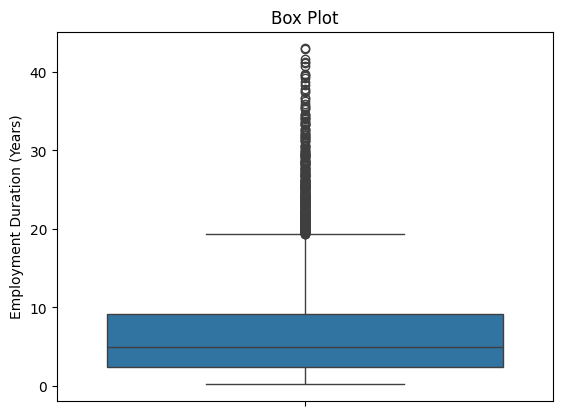

In [55]:
create_boxplot(cc_train_copy, 'employment_duration')

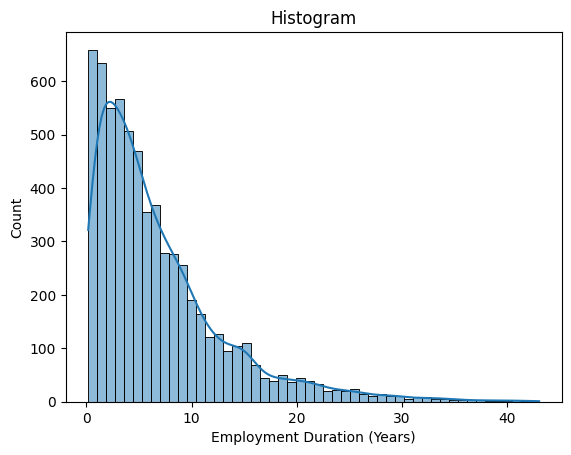

In [56]:
create_hist_plot(cc_train_copy, 'employment_duration')

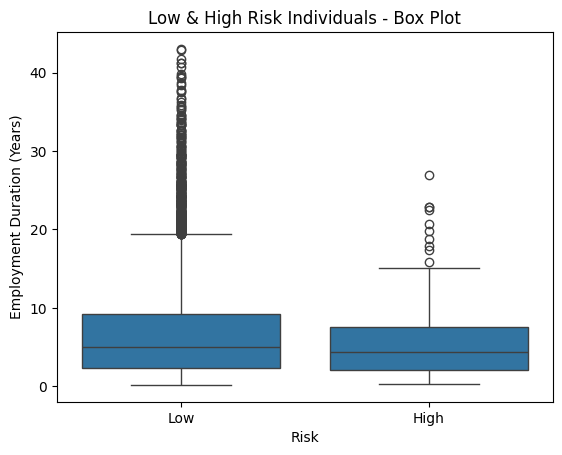

In [57]:
low_high_risk_boxplot(cc_train_copy, 'employment_duration')

**Interpretation**
- The majority of applicants have been employed for around 5 years.
- A significant portion of applicants are outliers, with some having been employed for over 20 years.
- The employment length distribution is positively skewed, indicating that most applicants have relatively shorter tenures while a few have much longer ones.
- High-risk applicants tend to have a shorter employment length, averaging 5 years, while low-risk applicants have a slightly longer average of 7 years.

**Note:** This analysis might not be fully accurate due to potential imbalance in the target variable, which could affect the reliability of the conclusions.

#### 3.4.12. **Own Car**

In [58]:
gen_info_feat(cc_application_df, 'owns_car')

Description:
count     9709
unique       2
top          N
freq      6139
Name: owns_car, dtype: object
**************************************************
Data type: object
**************************************************
          Count  Frequency (%)
owns_car                      
N          6139          63.23
Y          3570          36.77


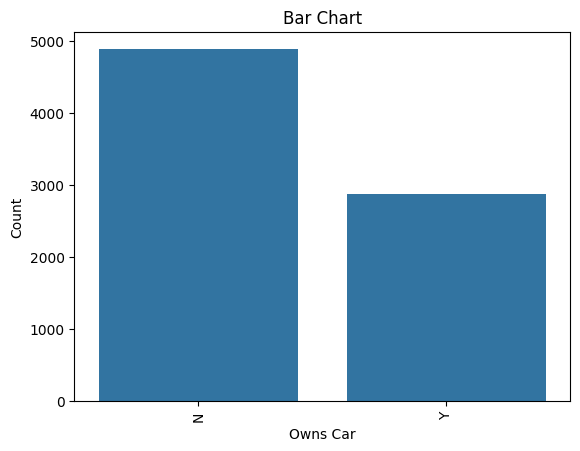

In [59]:
create_bar_plot(cc_train_copy, 'owns_car')

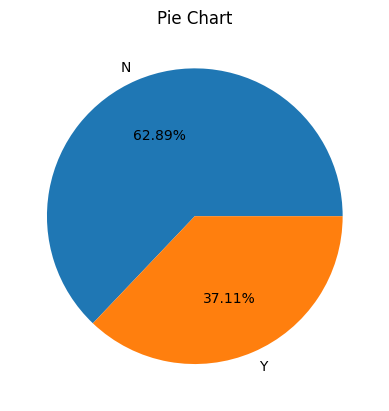

In [60]:
create_pie_plot(cc_train_copy, 'owns_car')

**Interpretation**
- The majority of applicants do not own a car.

#### 3.4.13. **Own Property**

In [61]:
gen_info_feat(cc_train_copy, 'owns_property')

Description:
count     7767
unique       2
top          Y
freq      5220
Name: owns_property, dtype: object
**************************************************
Data type: object
**************************************************
               Count  Frequency (%)
owns_property                      
Y               5220          67.21
N               2547          32.79


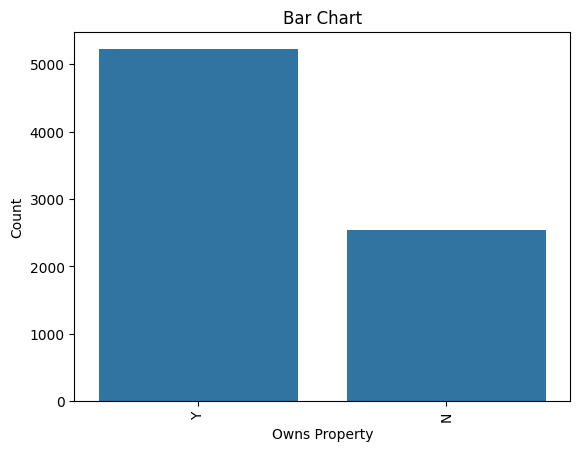

In [62]:
create_bar_plot(cc_train_copy, 'owns_property')

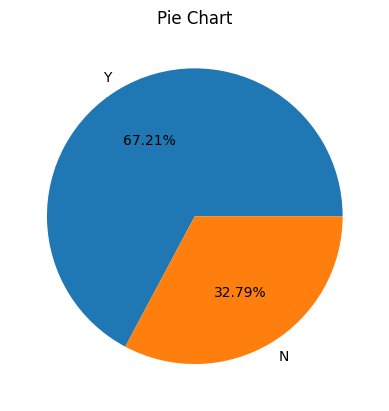

In [63]:
create_pie_plot(cc_train_copy, 'owns_property')

**Interpretation**
- The majority of applicants own a property.

#### 3.4.14. **Has Work Phone**

In [64]:
gen_info_feat(cc_train_copy, 'has_work_phone')

Description:
count   7767.00
mean       0.22
std        0.41
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: has_work_phone, dtype: float64
**************************************************
Data type: int64
**************************************************
                Count  Frequency (%)
has_work_phone                      
0                6060          78.02
1                1707          21.98


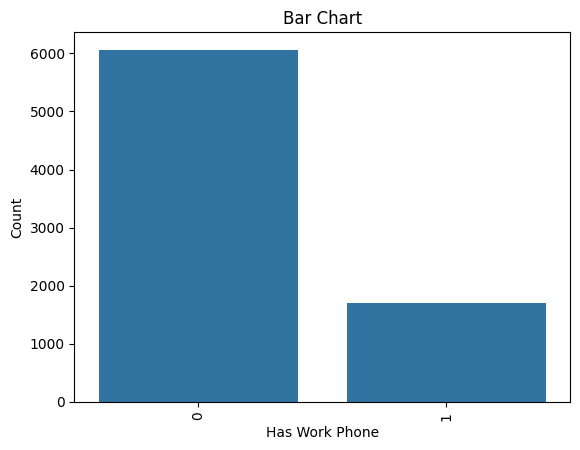

In [65]:
create_bar_plot(cc_train_copy, 'has_work_phone')

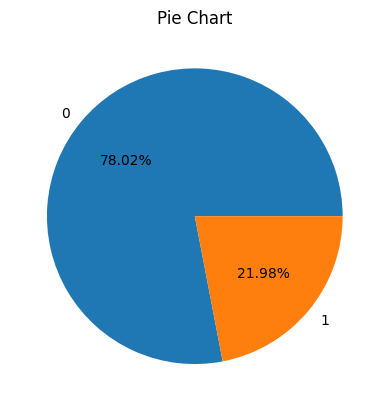

In [66]:
create_pie_plot(cc_train_copy, 'has_work_phone')

**Note:** Here `0` represents *No*, and `1` represents *Yes*.

**Interpretation**
- More than ¾ of applicants do not have a work phone.

#### 3.4.15. **Has Mobile**

In [67]:
gen_info_feat(cc_train_copy, 'has_mobile')

Description:
count   7767.00
mean       1.00
std        0.00
min        1.00
25%        1.00
50%        1.00
75%        1.00
max        1.00
Name: has_mobile, dtype: float64
**************************************************
Data type: int64
**************************************************
            Count  Frequency (%)
has_mobile                      
1            7767         100.00


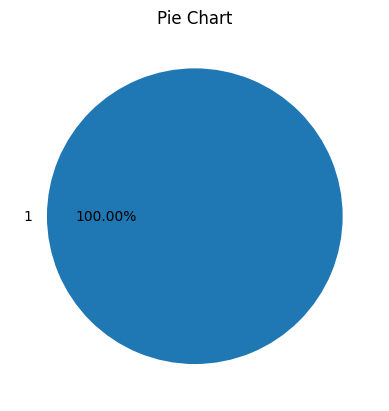

In [68]:
create_pie_plot(cc_train_copy, 'has_mobile')

**Note:** Here `0` represents *No*, and `1` represents *Yes*.

**Interpretation**
- All applicants, without exception, have a mobile phone.

#### 3.4.16. **Has Phone**

In [69]:
gen_info_feat(cc_train_copy, 'has_phone')

Description:
count   7767.00
mean       0.29
std        0.45
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00
Name: has_phone, dtype: float64
**************************************************
Data type: int64
**************************************************
           Count  Frequency (%)
has_phone                      
0           5517          71.03
1           2250          28.97


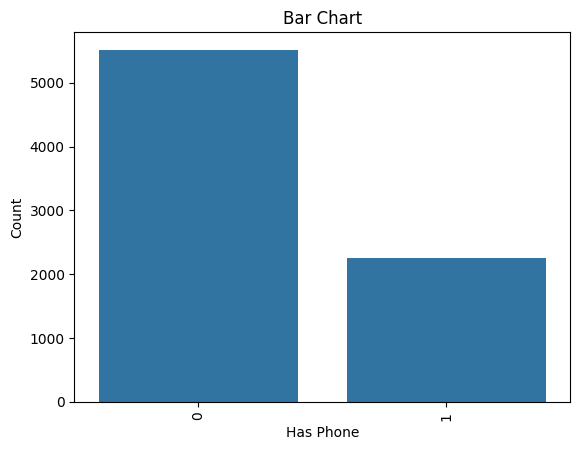

In [70]:
create_bar_plot(cc_train_copy, 'has_phone')

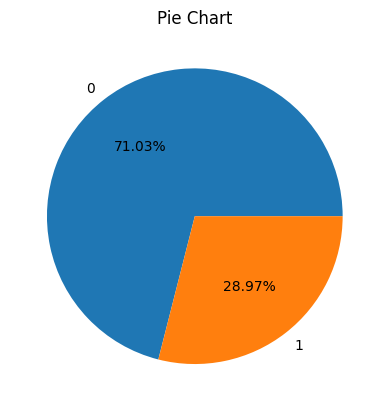

In [71]:
create_pie_plot(cc_train_copy, 'has_phone')

**Note:** Here `0` represents *No*, and `1` represents *Yes*.

**Interpretation**
- Most applicants don’t have a phone, which could likely be a home phone.

#### 3.4.17. **Has Email**

In [72]:
gen_info_feat(cc_train_copy, 'has_email')

Description:
count   7767.00
mean       0.09
std        0.28
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: has_email, dtype: float64
**************************************************
Data type: int64
**************************************************
           Count  Frequency (%)
has_email                      
0           7085          91.22
1            682           8.78


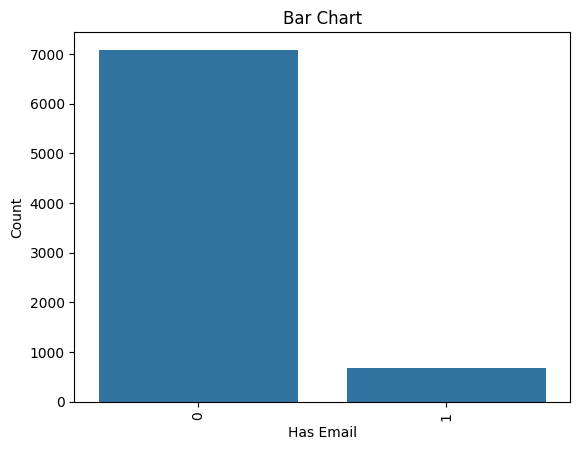

In [73]:
create_bar_plot(cc_train_copy, 'has_email')

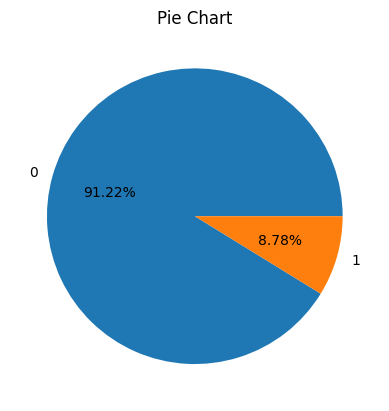

In [74]:
create_pie_plot(cc_train_copy, 'has_email')

**Note:** Here `0` represents *No*, and `1` represents *Yes*.

**Interpretation**
- More than 90% of applicants don’t have an email.

#### 3.4.18. **Account Age (Months)**

In [75]:
gen_info_feat(cc_train_copy, 'account_age_(months)')

Description:
count   7767.00
mean      27.35
std       16.60
min        0.00
25%       13.00
50%       26.00
75%       41.00
max       60.00
Name: account_age_(months), dtype: float64
**************************************************
Data type: int64


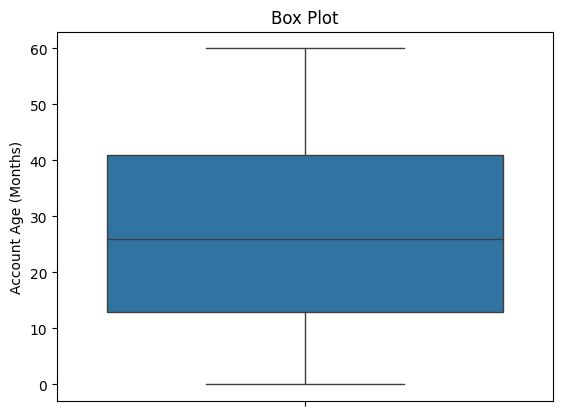

In [76]:
create_boxplot(cc_train_copy, 'account_age_(months)')

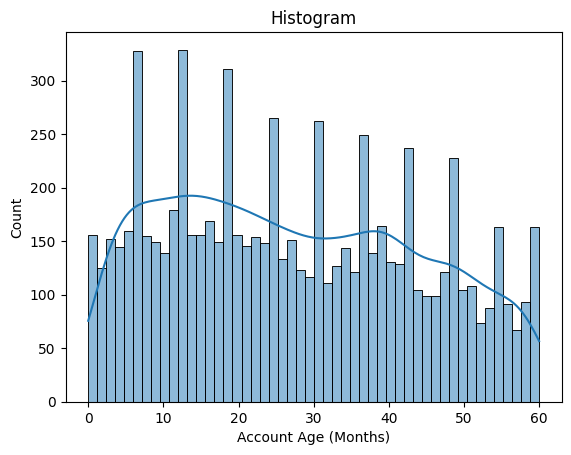

In [77]:
create_hist_plot(cc_train_copy, 'account_age_(months)')

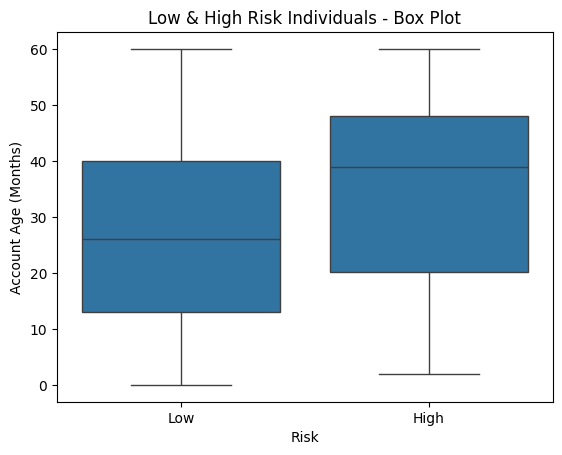

In [78]:
low_high_risk_boxplot(cc_train_copy, 'account_age_(months)')

**Interpretation**
- Most accounts are 26 months old.
- Account age is not normally distributed; it is positively skewed.
- The accounts flagged as high risk are, on average, 39 months old, compared to 26 months old for low-risk accounts.

#### 3.4.19. **Is Risky (Target Variable)**

In [79]:
gen_info_feat(cc_train_copy, 'is_risky')

Description:
count   7767.00
mean       0.02
std        0.14
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: is_risky, dtype: float64
**************************************************
Data type: int64
**************************************************
          Count  Frequency (%)
is_risky                      
0          7605          97.91
1           162           2.09


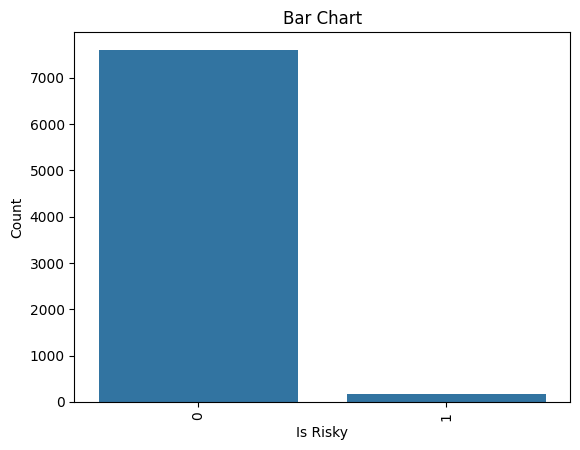

In [80]:
create_bar_plot(cc_train_copy, 'is_risky')

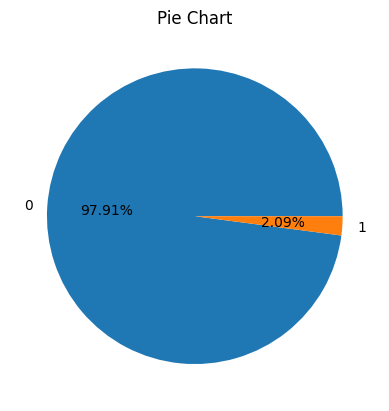

In [81]:
create_pie_plot(cc_train_copy, 'is_risky')

**Note:** Here `0` represents *Low-Risk*, and `1` represents *High-Risk*.

**Interpretation**
- A vast majority of applicants are low-risk applicants.
- The data is highly imbalanced.

### 3.5. **Bivariate Analysis**

#### 3.5.1. **Numerical vs Numerical (Scatter & Correlation Plots)**

##### 3.5.1.1. **Scatter Plot**

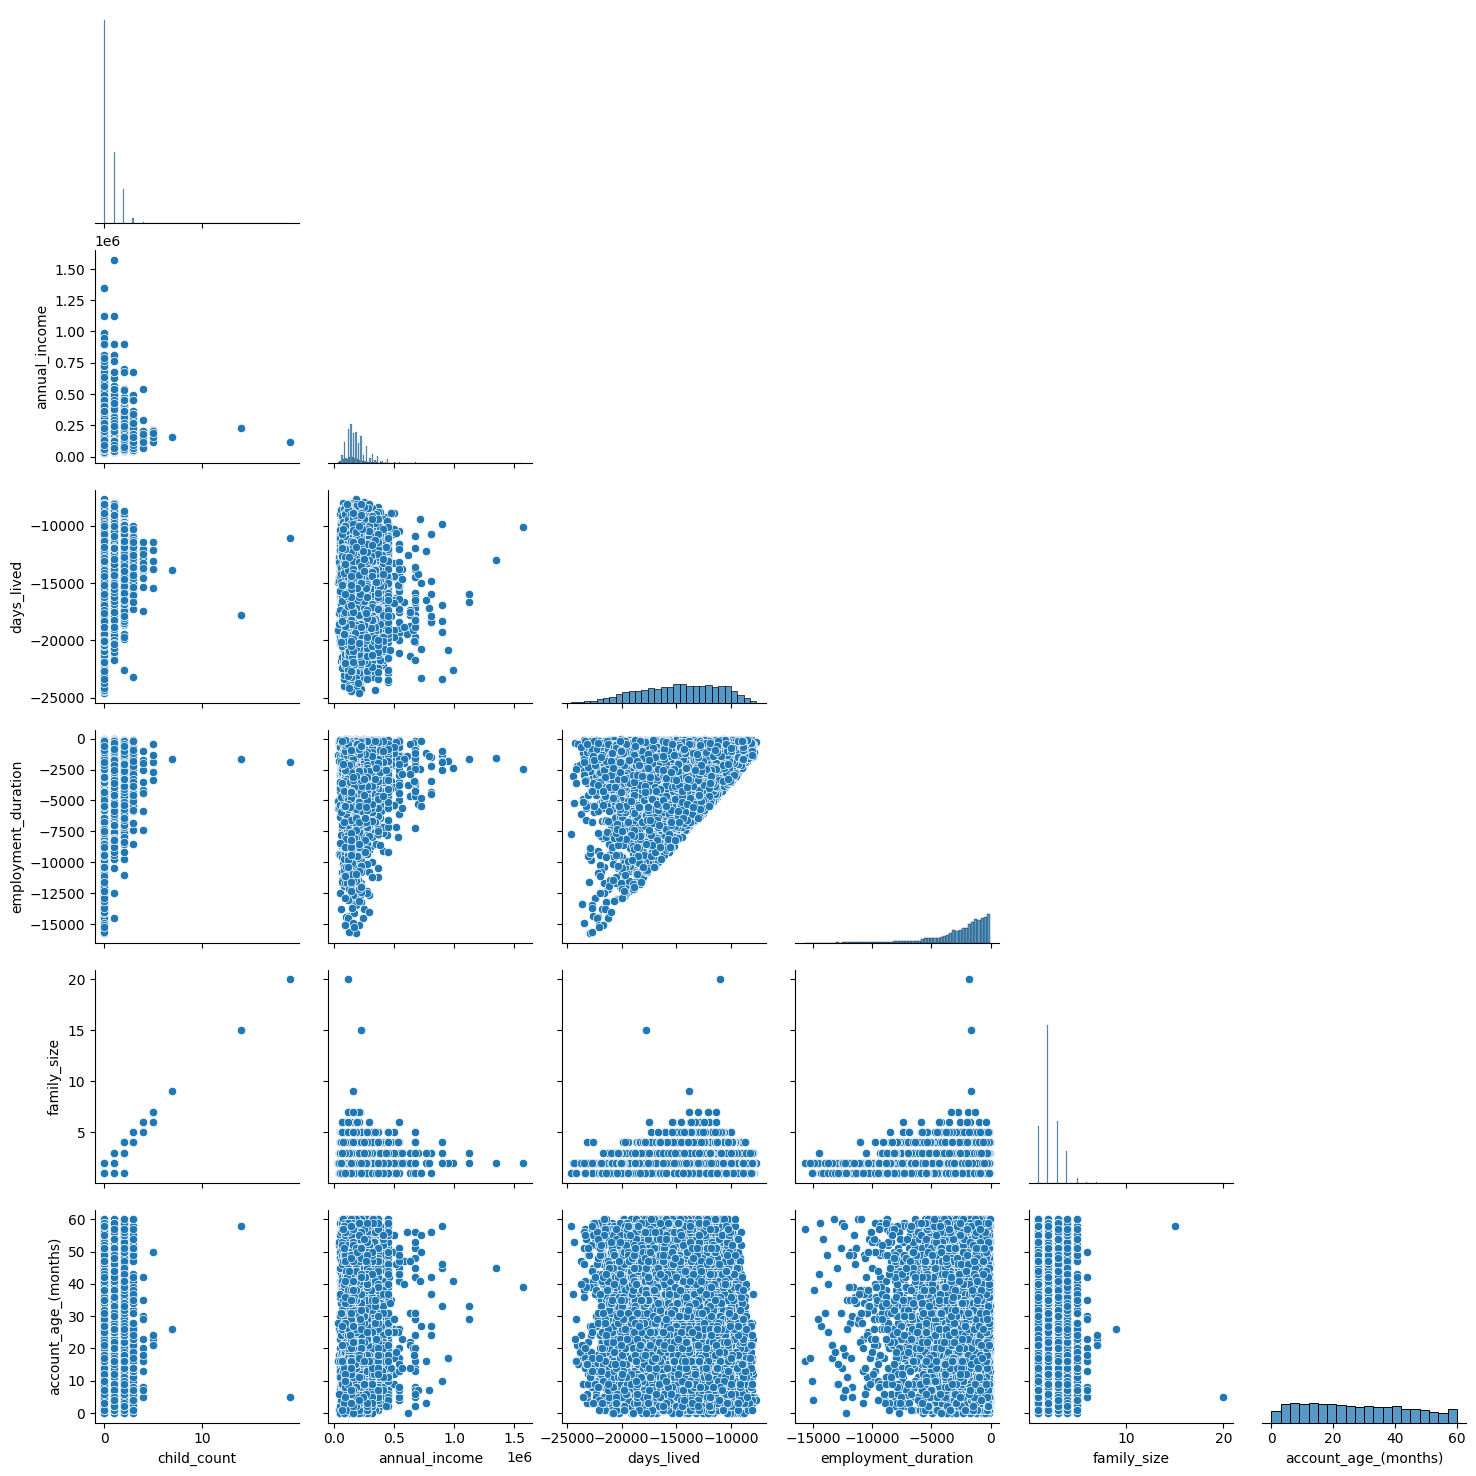

In [82]:
sns.pairplot(cc_train_original[cc_train_original['employment_duration'] < 0].drop(['ID', 'has_mobile', 'has_work_phone', 'has_phone', 'has_email','is_risky'],axis=1),corner=True)
plt.show()

**Interpretation**
- There is a **positive linear correlation** between **'family_size'** and the **'child_count'**, which is expected as more children naturally increase the **'family_size'**.
- This indicates a **multicollinearity issue**, where the two features are highly correlated. To address this, one of the variables should be dropped to avoid redundancy.
- Additionally, a **positive correlation** is observed between **'employment_duration'** and **'days_lived'**. This trend is intuitive since individuals with longer employment durations are generally older.

###### 3.5.1.1.1. **Family Size vs Children Count**

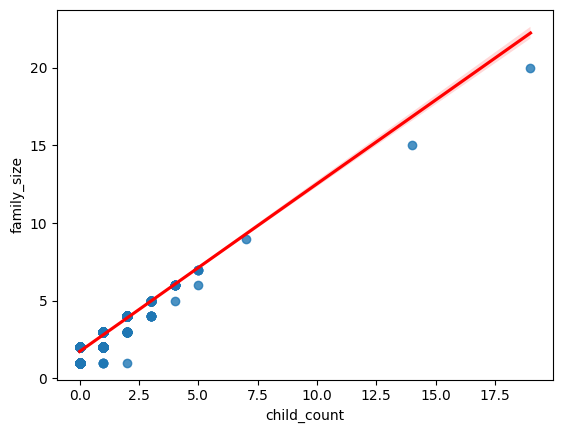

In [83]:
sns.regplot(x='child_count', y='family_size', data=cc_train_copy, line_kws={'color': 'red'})
plt.show()

**Interpretation**
- The more children a person has, the larger the family member count.

###### 3.5.1.1.2. **Account Age vs Age**

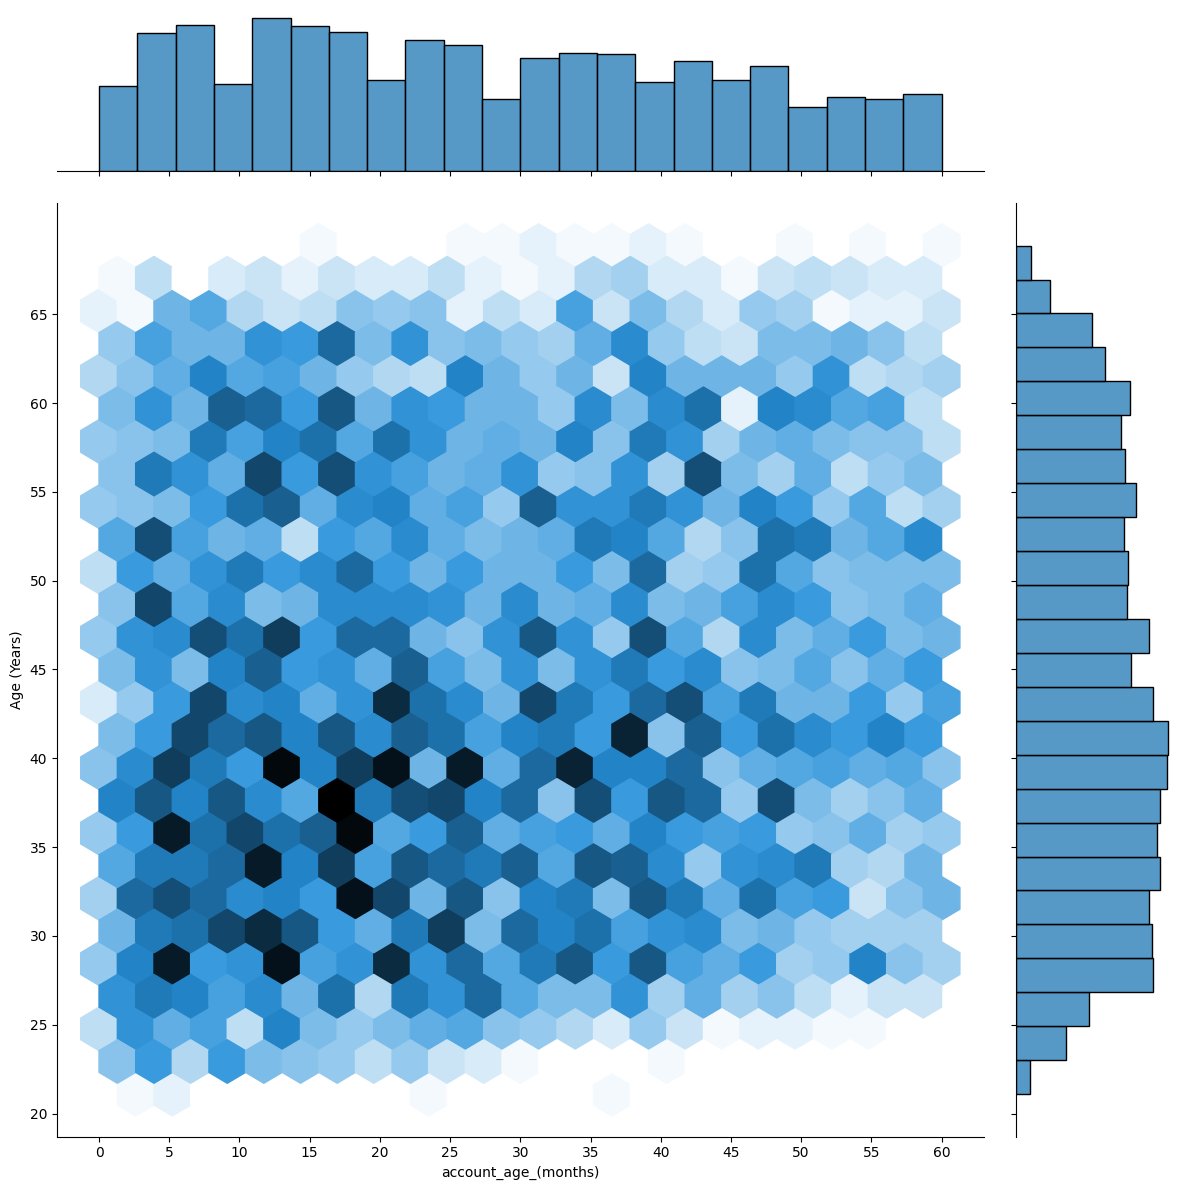

In [84]:
y_age = np.abs(cc_train_copy['days_lived']) / 365.25
sns.jointplot(x=np.abs(cc_train_copy['account_age_(months)']), y=y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age (Years)')
plt.show()

**Interpretation**
- Most of the applicants are between 25 to 45 years old and have an account that is less than 25 months old.

###### 3.5.1.1.3. **Employment Duration vs Age**

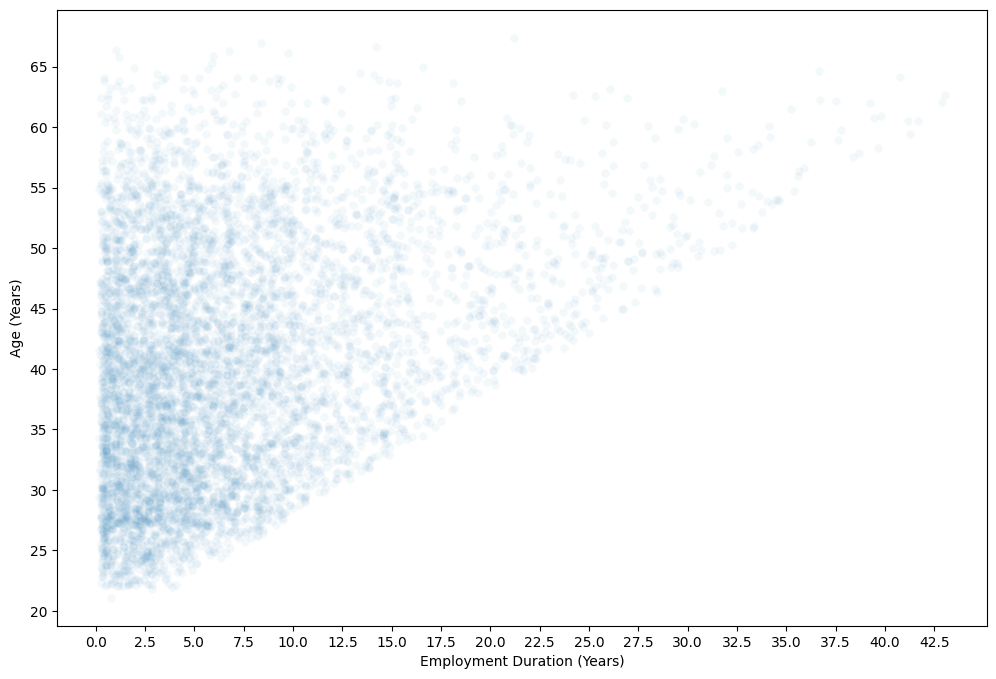

In [85]:
x_employ_length = np.abs(cc_train_copy.loc[cc_train_copy['employment_duration'] < 0, 'employment_duration']) / 365.25
y_age = cc_train_copy['days_lived'].abs() / 365.25
plt.figure(figsize=(12, 8))
sns.scatterplot(x=x_employ_length, y=y_age, alpha=0.05)
plt.xlabel('Employment Duration (Years)')
plt.ylabel('Age (Years)')
plt.xticks(np.arange(0, x_employ_length.max() + 1, 2.5))
plt.yticks(np.arange(20, y_age.max() + 1, 5))
plt.show()

**Interpretation**
- This scatterplot reveals a positive correlation between the age of applicants and the length of their employment. 
- The reversed triangular shape arises because, logically, an applicant's employment length cannot exceed their age. **i.e** Age > Employment Duration

##### 3.5.1.2. **Correlation Plot**

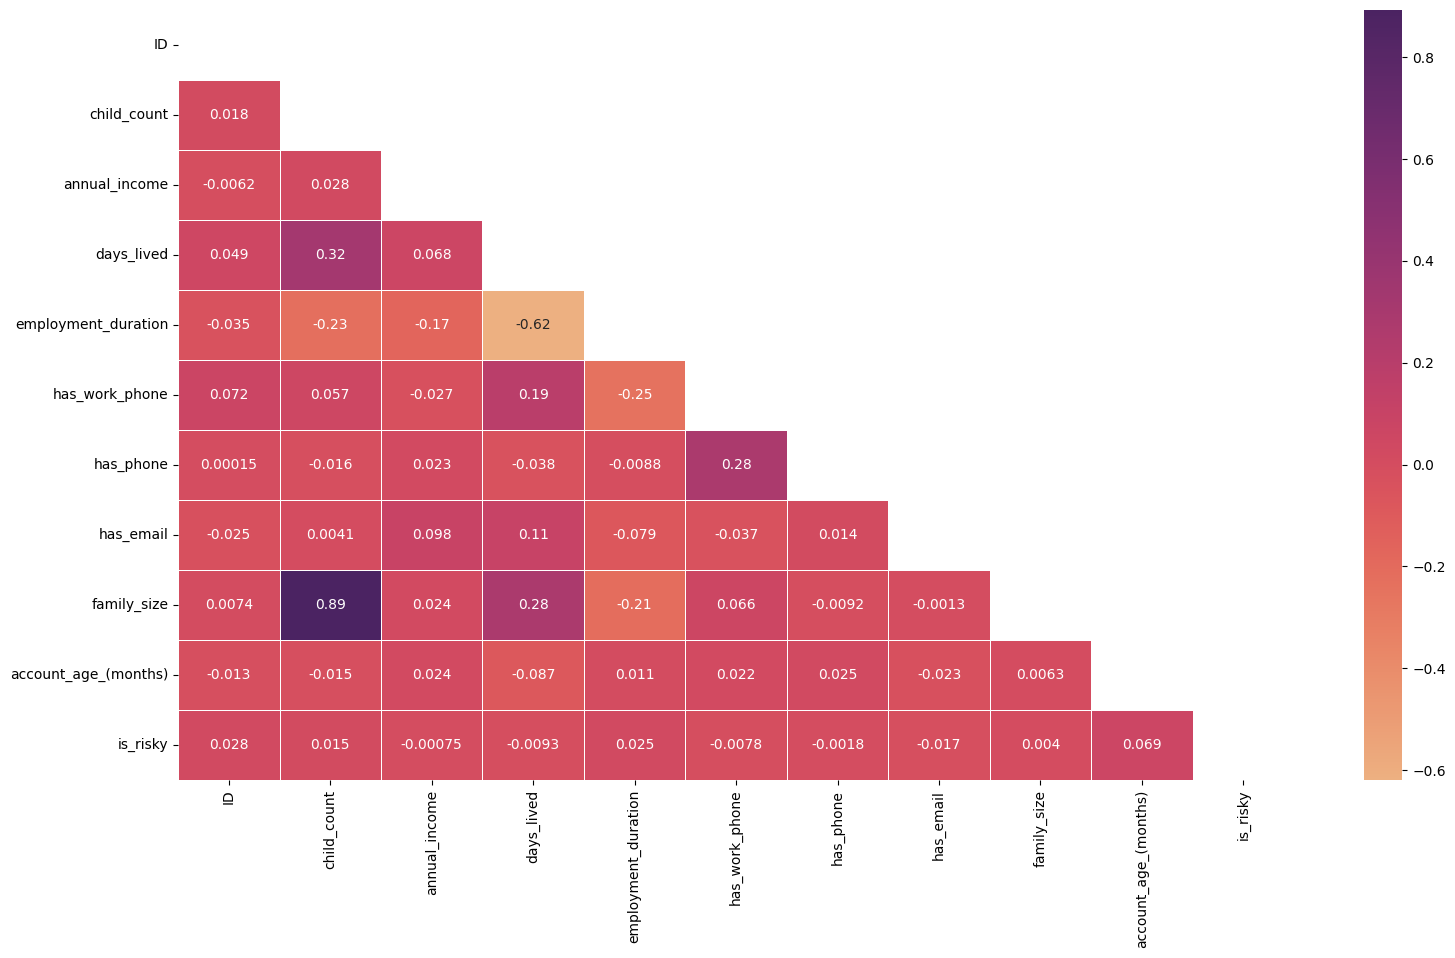

In [86]:
is_risky_int = cc_train_original['is_risky'].astype('int32')
cc_train_original_numeric = pd.concat([cc_train_original.drop(['has_mobile', 'is_risky'], axis=1), is_risky_int], axis=1).select_dtypes(include=[np.number])
cc_train_copy_corr_no_mobile = cc_train_original_numeric.corr()
mask = np.triu(np.ones_like(cc_train_copy_corr_no_mobile, dtype=bool))
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare', mask=mask, linewidths=0.5)
plt.show()

**Interpretation**
- The target column does not show significant correlation with any feature. 
- A strong positive correlation exists between **'family_size'** and **'child_count'**, confirming earlier findings.
- There is a mild positive correlation between **'age'** and **'family_size'**, suggesting that older individuals tend to have larger families.
- A slight positive correlation is also observed between **'age'** and **'has_work_phone'**, indicating that younger individuals are less likely to possess a work phone.
- There is a positive correlation between **has_phone** and **has_work_phone**.
- A negative correlation between **'employment_duration'** and **'age'** persists, aligning with previous observations.

#### 3.5.2. **Numerical vs Categorical (ANOVA)**

In [87]:
cat_features = ['gender', 'owns_car', 'owns_property', 'occupation', 'education', 'marital_status', 'accommodation', 'job_title']

##### 3.5.2.1. **Age vs Rest Features**

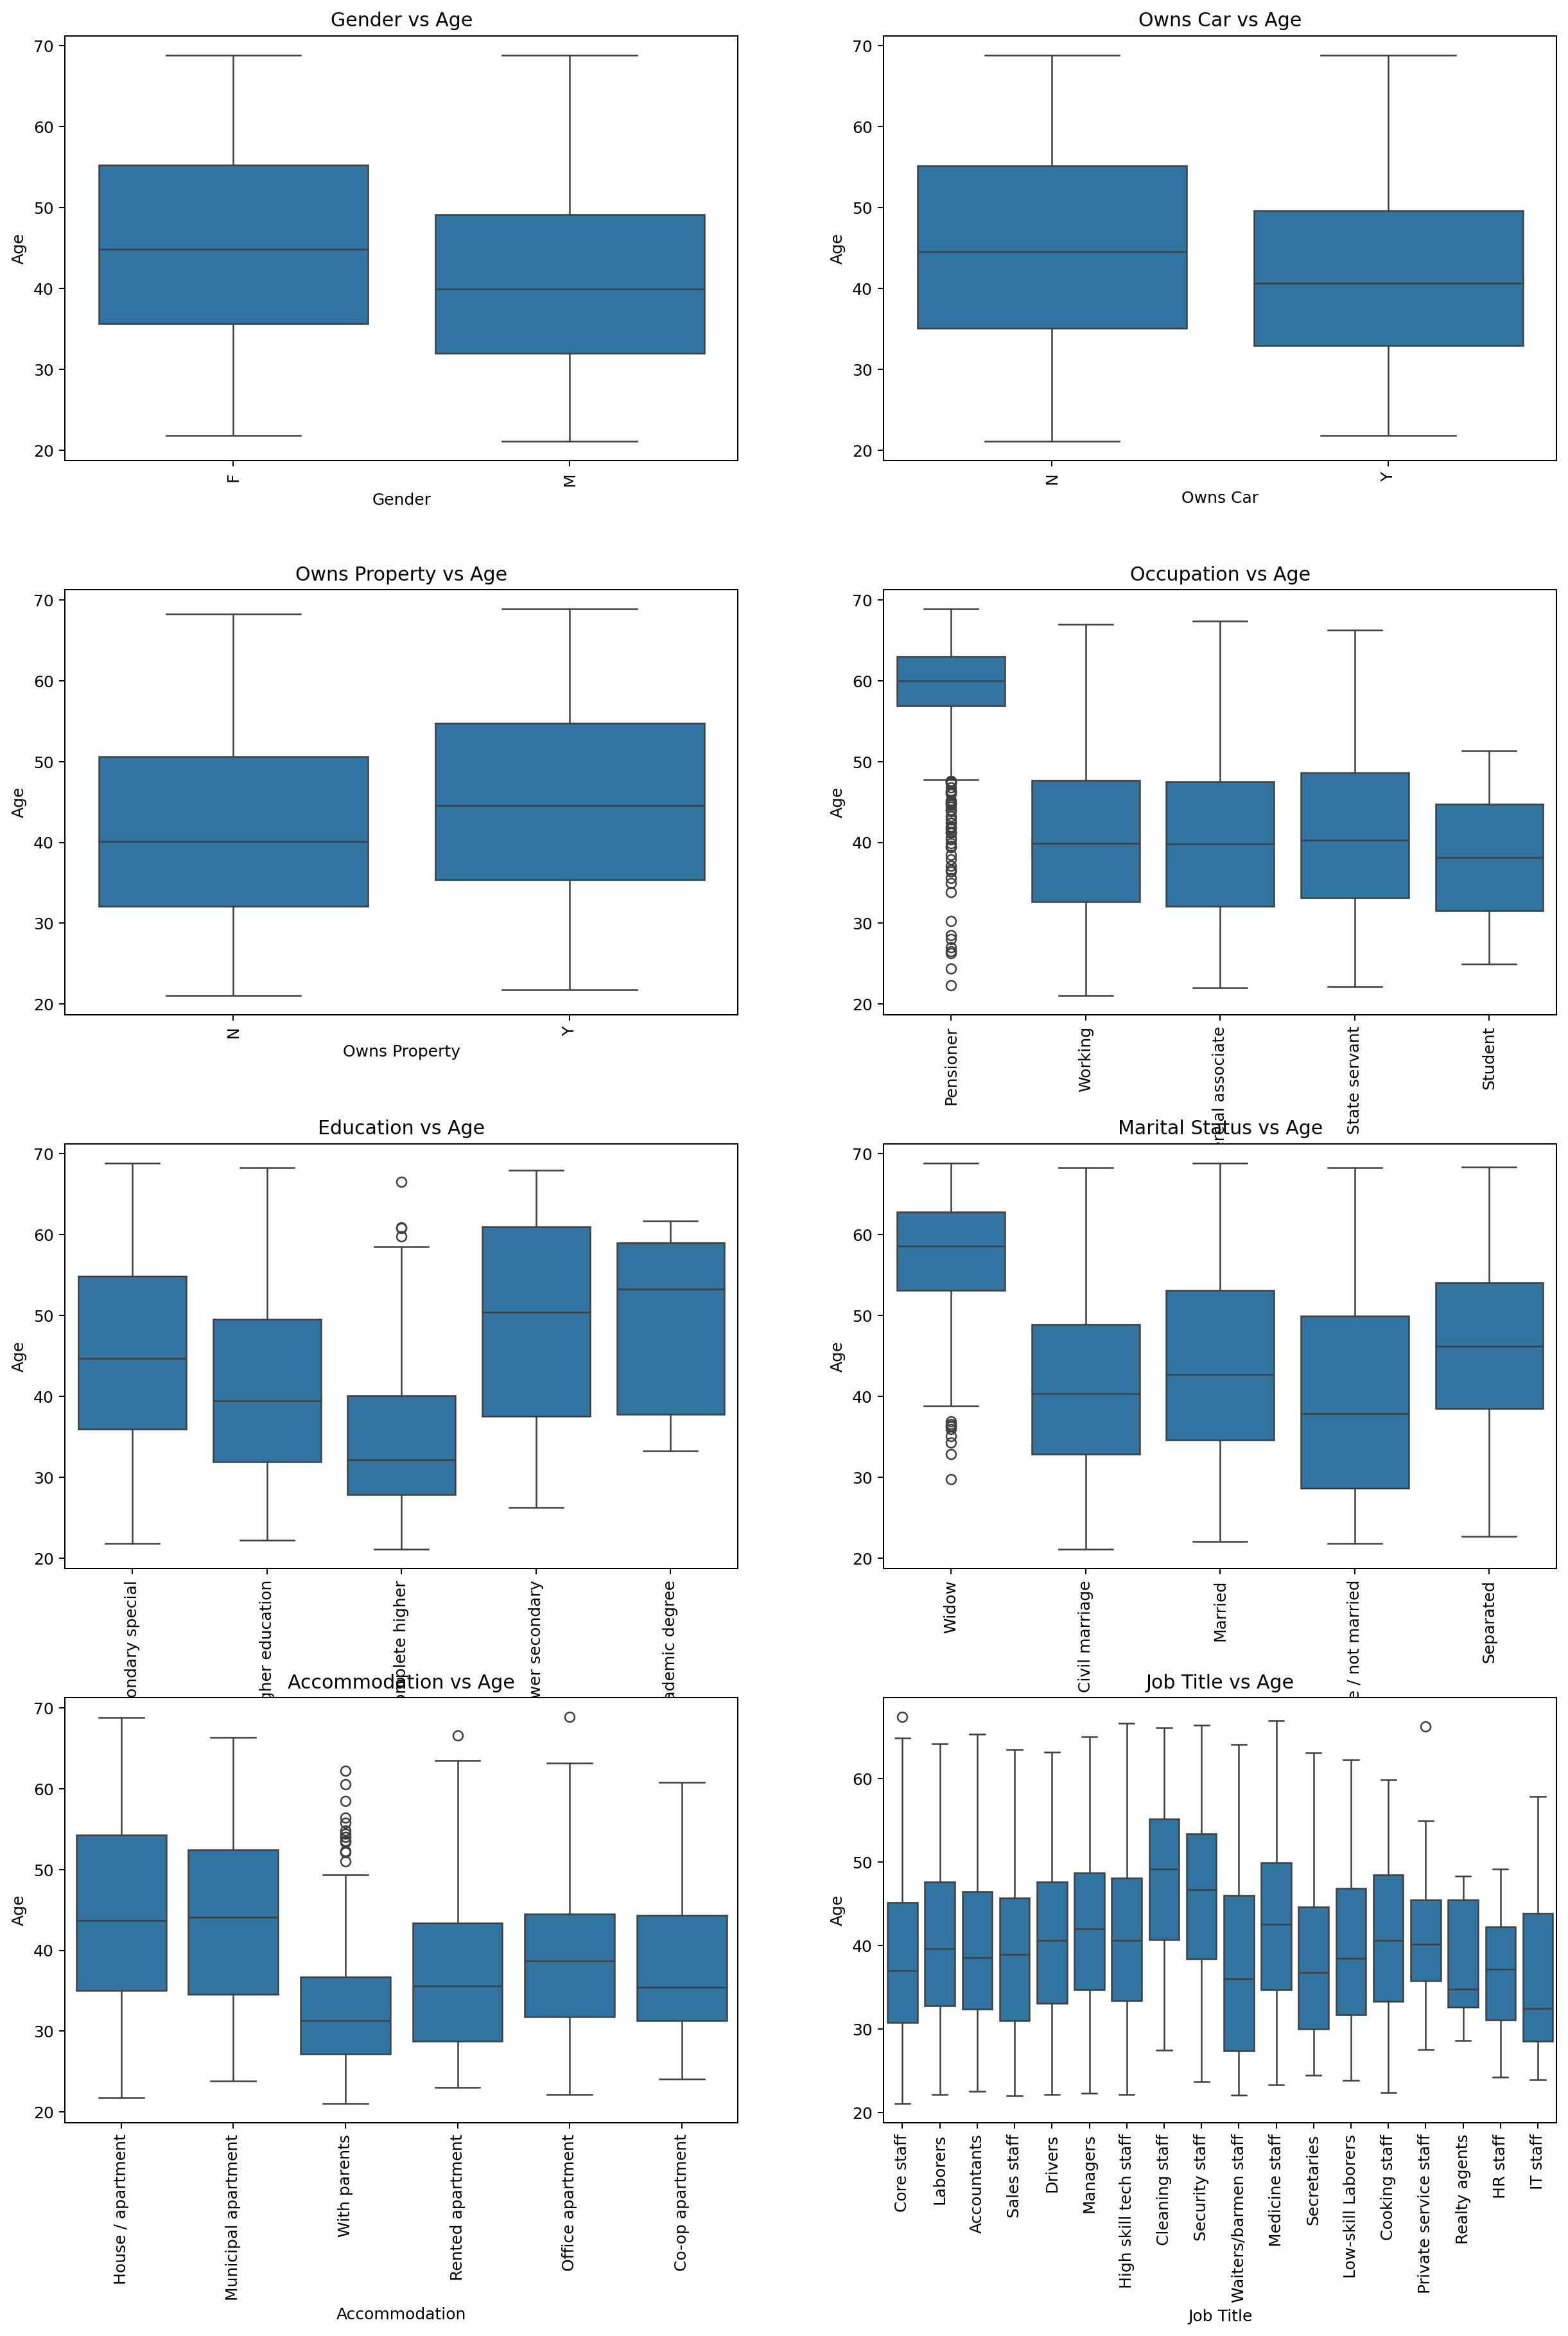

In [88]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20), dpi=180)
fig.tight_layout(pad=6.0)

for cat_ft_count, ax in enumerate(axes.flatten()):
    sns.boxplot(ax=ax, x=cc_train_copy[cat_features[cat_ft_count]], y=np.abs(cc_train_copy['days_lived']) / 365.25)
    ax.set_title(f"{cat_features[cat_ft_count].replace('_', ' ').title()} vs Age")
    ax.set_xlabel(f"{cat_features[cat_ft_count].replace('_', ' ').title()}")
    ax.set_ylabel("Age")
    ax.tick_params(axis='x', rotation=90)

plt.show()

**Interpretation**
- Female applicants are older than their male counterpart.
- Those who don't own a car tend to be older.
- Those who own a property tend to be older than those who don't.
- Of course, the pensioners are older that those who are working (We also see that some have pensioned at a young age, those are outliers).
- It is also interesting to see that those who hold an academic degree are younger in general than the other groups.
- Obviously, the widows tend to be much older. We also see some outliers in their 30's as well.
- With no surprise, those who live with parent tend to be younger. We also see some outlier as well.
- Lastly, who work as cleaning staff tend to be older while those who work in IT tend to be younger.

##### 3.5.2.2. **Employment Duration vs Rest Features**

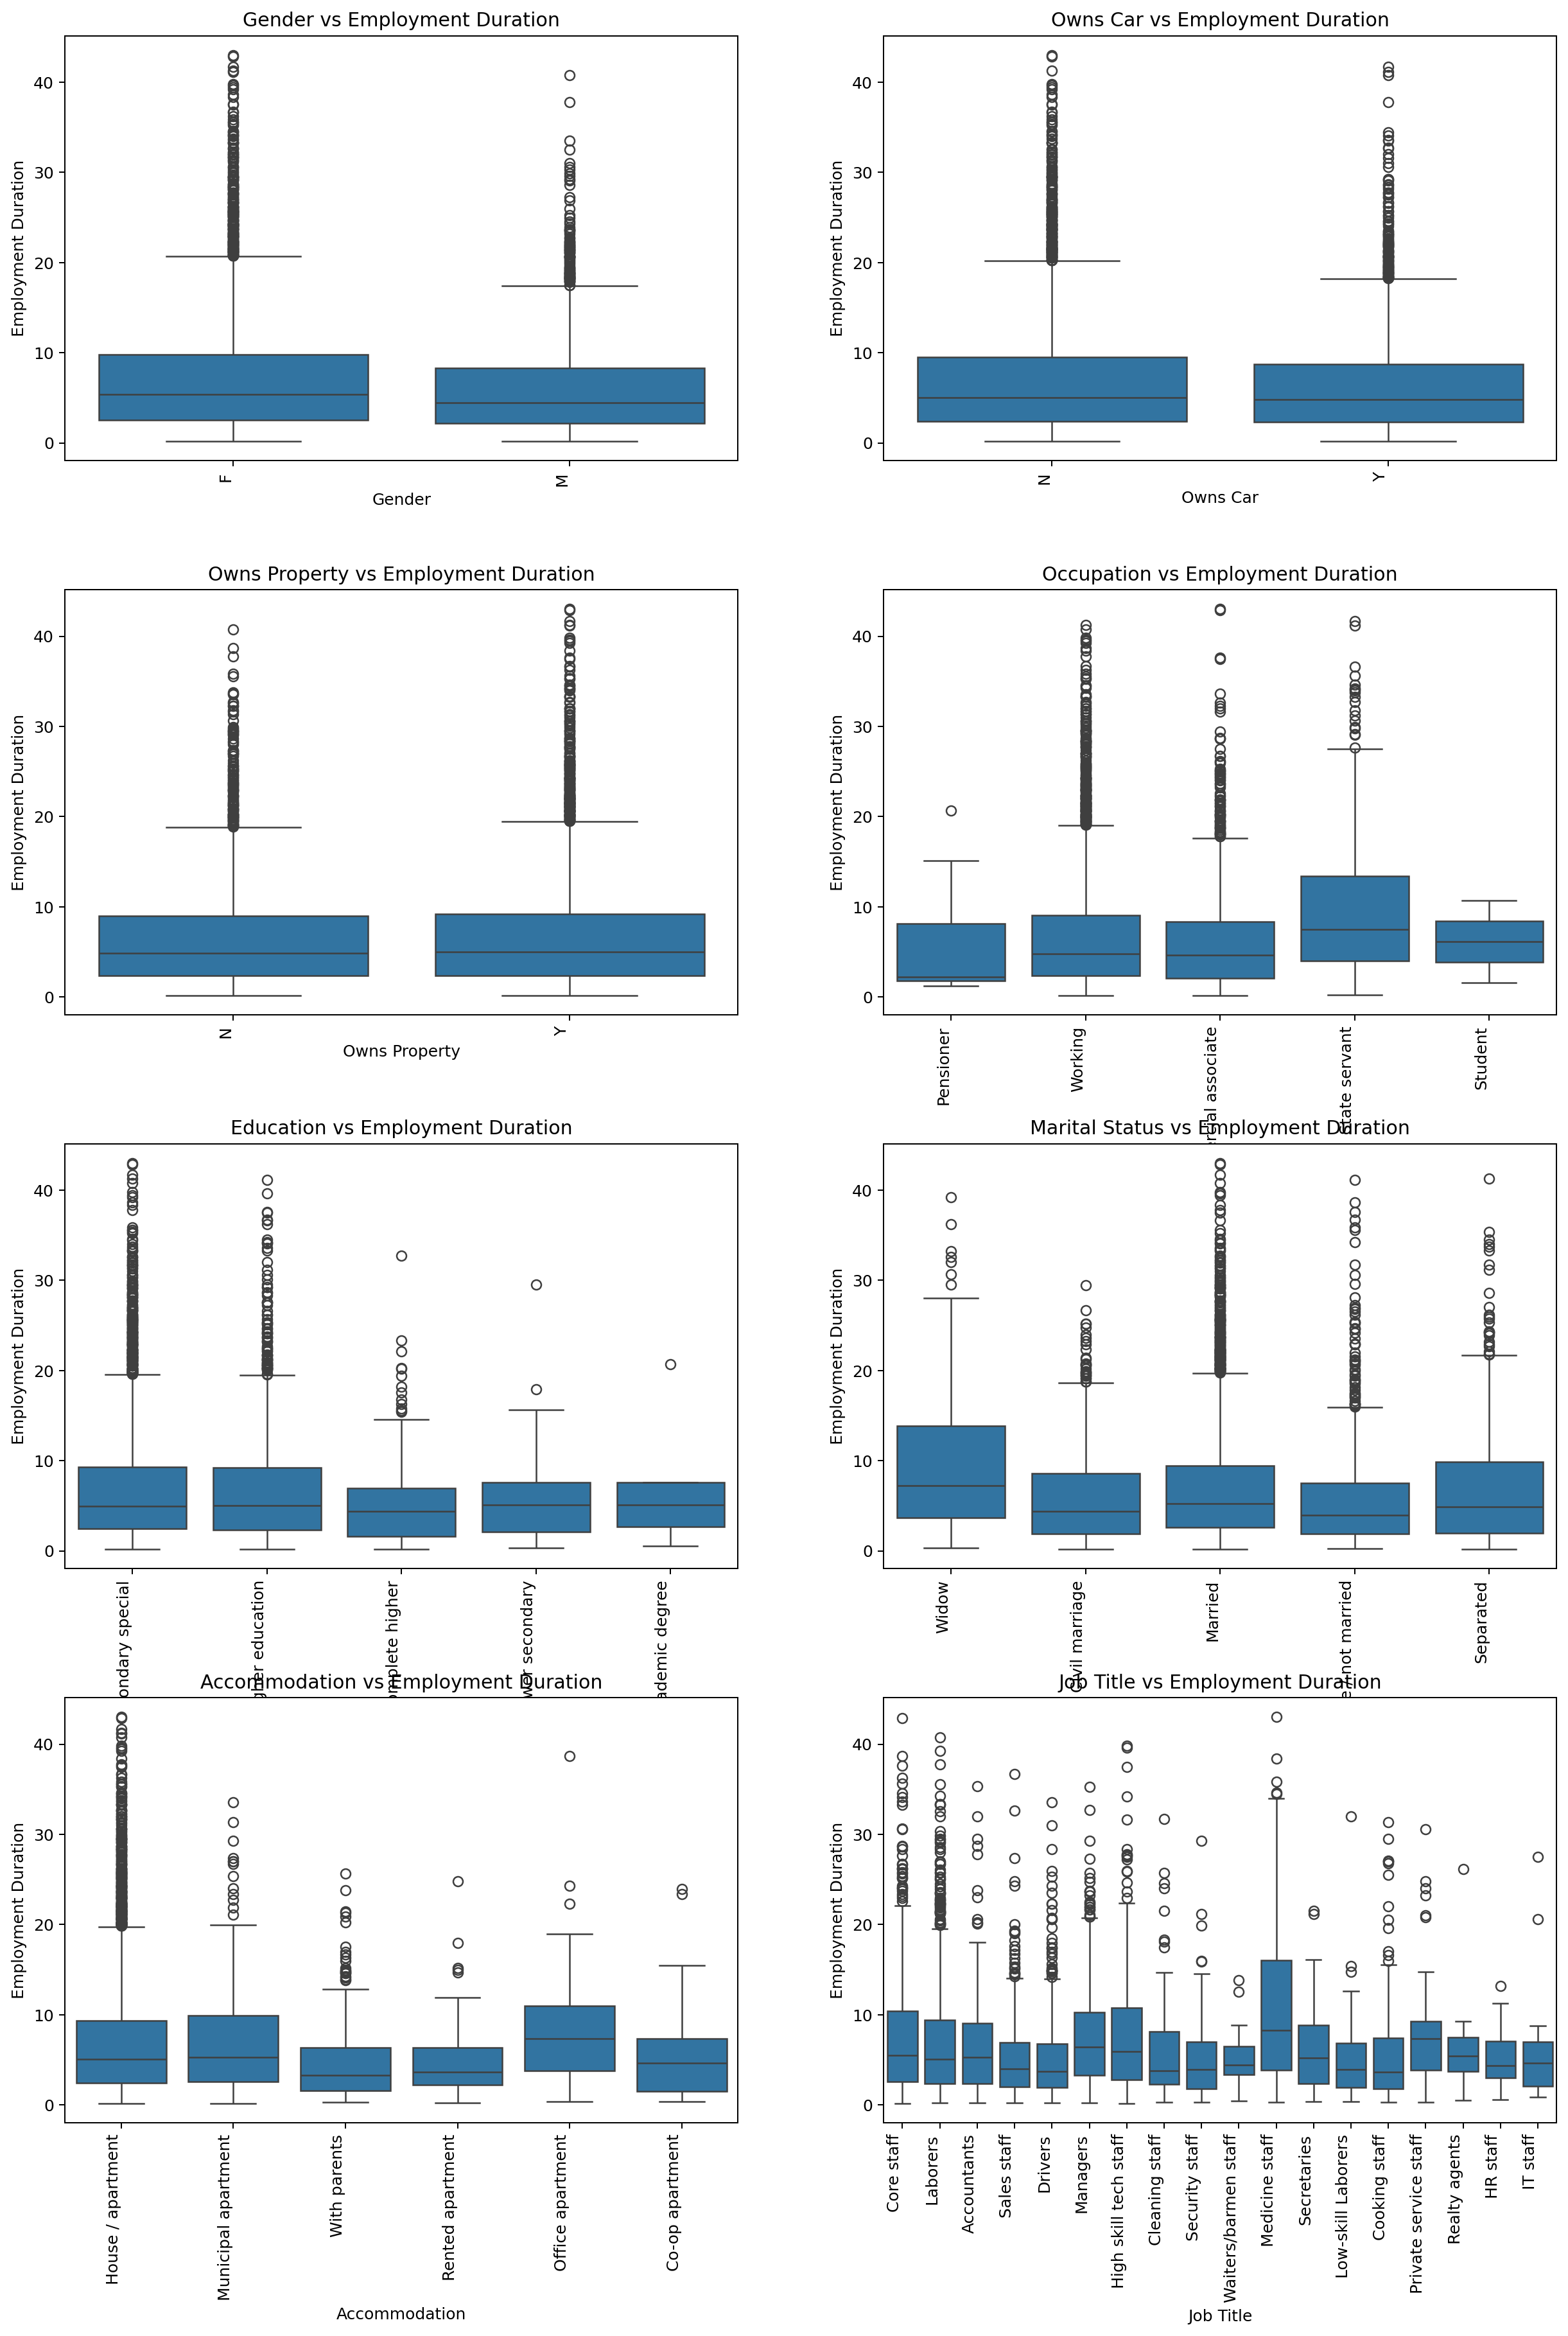

In [89]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20), dpi=180)
fig.tight_layout(pad=6.0)

for cat_ft_count, ax in enumerate(axes.flatten()):
    for row_count in range(4):
        for col_count in range(2):
            sns.boxplot(ax=axes[row_count,col_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy[cc_train_copy['employment_duration'] < 0]['employment_duration']) / 365.25)
            axes[row_count,col_count].set_title(f"{cat_features[cat_ft_count].replace('_', ' ').title()} vs Employment Duration")
            plt.sca(axes[row_count,col_count])
            plt.xlabel(f"{cat_features[cat_ft_count].replace('_', ' ').title()}")
            plt.ylabel("Employment Duration")
            plt.xticks(rotation=90, ha='right')
            cat_ft_count += 1
    break

plt.show()

**Interpretation**
- State employed applicant tend to have been employed longer than the rest.
- Those who work in the medical field, have been employed longer than the rest.

#### 3.5.3. **Categorical vs Categorical (Chi-Square Test)**

**Hypothesis Interpretation**
- **Null Hypothesis (H₀):** The feature's categories do not influence the target variable (`is_risky`).
- **Alternate Hypothesis (H₁)** At least one of the feature's categories significantly affects the target variable.

**Decision Process**
- **Chi-Square Statistic:** Quantifies the difference between the observed and expected frequencies for the feature's categories.
- **Critical Value:** Calculated at a specified confidence level (95% here), using the degrees of freedom.
- **P-Value:** The probability of observing the test statistic (or one more extreme) under the null hypothesis.

**Outcomes**
- **Reject the Null Hypothesis (H₀):** If `Chi-Square Statistic ≥ Critical Value` Or `P-Value < 0.05`
- **Fail to reject the Null Hypothesis (H₀):** If `Chi-Square Statistic < Critical Value` Or `P-Value ≥ 0.05`

In [90]:
def chi_func(feature):
    # Select rows where 'is_risky' is 1 and extract the feature column
    high_risk_values = cc_train_copy.loc[cc_train_copy['is_risky'] == 1, feature]
    
    # Calculate observed values (frequency counts)
    observed_counts = high_risk_values.value_counts().sort_index().to_frame(name='Observed')
    print("Observed values:\n", observed_counts, "\n")
    
    # Calculate expected values (uniform distribution)
    total_count = observed_counts['Observed'].sum()
    expected_value = total_count / len(observed_counts)
    expected_counts = pd.DataFrame(
        [expected_value] * len(observed_counts), 
        columns=['Expected'], 
        index=observed_counts.index
    )
    print("Expected values:\n", expected_counts, "\n")
    
    # Perform chi-square calculation
    chi_squared_stat = (((observed_counts['Observed'] - expected_counts['Expected']) ** 2) / 
                        expected_counts['Expected']).sum()
    print("Chi-square statistic:", chi_squared_stat)
    
    # Critical value (95% confidence level)
    degrees_of_freedom = len(observed_counts) - 1
    critical_value = stats.chi2.ppf(q=0.95, df=degrees_of_freedom)
    print("Critical value:", critical_value)
    
    # P-value
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=degrees_of_freedom)
    print("P-value:", p_value)
    
    # Hypothesis testing decision
    if chi_squared_stat >= critical_value:
        print("\nReject the Null Hypothesis (H₀)")
    else:
        print("\nFail to reject the Null Hypothesis (H₀)")

In [91]:
cat_ft = ['owns_car', 'owns_property', 'employment_duration', 'education', 'marital_status', 'accommodation', 'job_title']
print('**** {} ****'.format('gender'))
chi_func('gender')
for ft in cat_ft:
    print('\n\n**** {} ****\n'.format(ft))
    chi_func(ft)

**** gender ****
Observed values:
         Observed
gender          
F             87
M             75 

Expected values:
         Expected
gender          
F          81.00
M          81.00 

Chi-square statistic: 0.8888888888888888
Critical value: 3.841458820694124
P-value: 0.3457785861511601

Fail to reject the Null Hypothesis (H₀)


**** owns_car ****

Observed values:
           Observed
owns_car          
N              101
Y               61 

Expected values:
           Expected
owns_car          
N            81.00
Y            81.00 

Chi-square statistic: 9.876543209876543
Critical value: 3.841458820694124
P-value: 0.001673991368624561

Reject the Null Hypothesis (H₀)


**** owns_property ****

Observed values:
                Observed
owns_property          
N                    71
Y                    91 

Expected values:
                Expected
owns_property          
N                 81.00
Y                 81.00 

Chi-square statistic: 2.4691358024691357
Critical val

### 3.6. **Findings from the Exploratory Data Analysis (EDA)**

- **Applicant Profile**  
  The typical applicant exhibits the following characteristics:  
  - **Demographics:** A female in her early 40s, married with a partner, and without children.  
  - **Employment:** Has been employed for approximately 5 years, earning an annual salary of ₹157,500.  
  - **Education:** Completed secondary education.  
  - **Assets:** Does not own a car but owns a property (house/apartment).  
  - **Account Details:** The account is 26 months old.  

- **Age and Income** features do not have any effects on the target variable (`is_risky`).  

- **Bad Client Traits**
  - Tend to have shorter employment lengths.
  - Typically hold older accounts.
  - Represent less than 2% of the total applicant population.

- **Applicant Distribution**
  - Most applicants are 20 to 45 years old.
  - The majority have accounts that are 25 months old or less.

## 4. **Prepare the Data**

### 4.1. **Transformations for Each Feature**

- **ID:** Drop the Column.
- **Gender:** Apply one-hot encoding.  
- **Age:**  
  - Apply Min-Max scaling.  
  - Convert to absolute value and divide by 365.25 (to represent years).  
- **Marital Status:** Apply one-hot encoding.  
- **Family Size:**  
  - Address outliers.  
  - Analyze correlation with the target variable and decide whether to retain this column or drop `child_count`.  
- **Child Count:**  
  - Address outliers.  
  - Analyze correlation with the target variable and decide whether to retain this column or drop `family_size`.  
- **Accommodation:** Apply one-hot encoding.  
- **Owns Car:** Convert to numerical and apply one-hot encoding.  
- **Owns Property:** Convert to numerical and apply one-hot encoding.  
- **Annual Income:**  
  - Remove outliers.  
  - Fix skewness.  
  - Apply Min-Max scaling.  
- **Employment Duration:**  
  - Remove outliers.  
  - Fix skewness.  
  - Apply Min-Max scaling.  
  - Convert to absolute value and divide by 365.25.  
  - Set employment duration for retirees to 0.  
- **Job Title:**  
  - Apply one-hot encoding.  
  - Impute missing values.  
- **Occupation:** Apply one-hot encoding.  
- **Education:** Apply ordinal encoding.  
- **Has Mobile:** Drop the column.  
- **Has Work Phone:** Apply one-hot encoding.  
- **Has Phone:** Apply one-hot encoding.  
- **Has Email:** Apply one-hot encoding.  
- **Account Age:**  
  - Apply Min-Max scaling.  
  - Convert to absolute value.  
- **Is Risky (Target):** Balance the data using SMOTE (Synthetic Minority Oversampling Technique).  

### 4.2. **Data Cleaning**

#### 4.2.1. **Outliers Handling**

In [92]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers=['family_size', 'child_count', 'annual_income', 'employment_duration']):
        self.feat_with_outliers = feat_with_outliers

    def fit(self, df):
        return self

    def transform(self, df):
        if set(self.feat_with_outliers).issubset(df.columns):
            # 25% and 75% quantiles
            Q1 = df[self.feat_with_outliers].quantile(0.25)
            Q3 = df[self.feat_with_outliers].quantile(0.75)
            IQR = Q3 - Q1
            # Keep data within 1.5 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) | (df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 4.3. **Feature Selection**

#### 4.3.1. **Drop Features**

In [93]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=['ID', 'has_mobile', 'child_count', 'job_title']):
        self.features_to_drop = features_to_drop

    def fit(self, df):
        return self

    def transform(self, df):
        if set(self.features_to_drop).issubset(df.columns):
            df.drop(self.features_to_drop, axis=1, inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 4.4. **Feature Engineering**

#### 4.4.1. **Time Conversion**

In [94]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days=['employment_duration', 'days_lived'], feat_with_months=['account_age_(months)']):
        self.feat_with_days = feat_with_days
        self.feat_with_months = feat_with_months

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if set(self.feat_with_days).issubset(X.columns) and set(self.feat_with_months).issubset(X.columns):
            # Convert days to years and months to absolute values
            X[self.feat_with_days] = np.abs(X[self.feat_with_days]) / 365.25
            X[self.feat_with_months] = np.abs(X[self.feat_with_months])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

#### 4.4.2. **Retiree Handling**

In [95]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df):
        return self

    def transform(self, df):
        if 'employment_duration' in df.columns:
            # Set retiree employment duration to 0
            df_ret_idx = df['employment_duration'][df['employment_duration'] == 999.98083504449].index
            df.loc[df_ret_idx,'employment_duration'] = 0
            return df
        else:
            print("Employment duration is not in the dataframe")
            return df

#### 4.4.3. **Skewness Handling**

In [96]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_skewness=['annual_income', 'days_lived']):
        self.feat_with_skewness = feat_with_skewness

    def fit(self, df):
        return self

    def transform(self, df):
        if set(self.feat_with_skewness).issubset(df.columns):
            # Apply cubic root transformation to handle skewness
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 4.4.4. **Binning**

In [97]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_num_enc=['has_work_phone', 'has_phone', 'has_email']):
        self.feat_with_num_enc = feat_with_num_enc

    def fit(self, df):
        return self

    def transform(self, df):
        if set(self.feat_with_num_enc).issubset(df.columns):
            # Map 0 to 'N' and 1 to 'Y'
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 4.4.5. **One Hot Encoding**

In [98]:
class OneHotWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_enc_ft=['gender', 'marital_status', 'accommodation', 'occupation', 'owns_car', 'owns_property', 'has_work_phone', 'has_phone', 'has_email']):
        self.one_hot_enc_ft = one_hot_enc_ft

    def fit(self, df):
        return self

    def transform(self, df):
        if set(self.one_hot_enc_ft).issubset(df.columns):
            def one_hot_enc(df, one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(), columns=feat_names_one_hot_enc, index=df.index)
                return df
            def concat_with_rest(df, one_hot_enc_df, one_hot_enc_ft):
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]], axis=1)
                return df_concat
            one_hot_enc_df = one_hot_enc(df, self.one_hot_enc_ft)
            full_df_one_hot_enc = concat_with_rest(df, one_hot_enc_df, self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

#### 4.4.6. **Ordinal Encoding**

In [99]:
class OrdinalFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_enc_ft=['education']):
        self.ordinal_enc_ft = ordinal_enc_ft

    def fit(self, df):
        return self

    def transform(self, df):
        if 'education' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

#### 4.4.7. **Min-Max Scaling**

In [100]:
class MinMaxWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, min_max_scaler_ft=['days_lived', 'annual_income', 'account_age_(months)', 'employment_duration']):
        self.min_max_scaler_ft = min_max_scaler_ft

    def fit(self, df):
        return self

    def transform(self, df):
        if set(self.min_max_scaler_ft).issubset(df.columns):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 4.4.8. **Oversampling with SMOTE**

In [101]:
class OversampleSMOTE(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df):
        return self

    def transform(self, df):
        if 'is_risky' in df.columns:
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(df.iloc[:,:-1], df.iloc[:,-1].astype('int64'))
            df_bal = pd.concat([pd.DataFrame(X_bal), pd.DataFrame(y_bal)], axis=1)
            return df_bal
        else:
            print("Is risky column is not in the dataframe")
            return df

### 4.5. **Data Preprocessing**

In [102]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('oversample_smote', OversampleSMOTE())
    ])
    return pipeline.fit_transform(df)

In [103]:
# Disable chained assignment warning
pd.options.mode.chained_assignment = None
df_prep = full_pipeline(cc_train_original)
print(df_prep.shape)

(11192, 35)


In [104]:
df_prep

,gender_F,gender_M,marital_status_Civil marriage,marital_status_Married,marital_status_Separated,marital_status_Single / not married,marital_status_Widow,accommodation_Co-op apartment,accommodation_House / apartment,accommodation_Municipal apartment,...,has_phone_Y,has_email_N,has_email_Y,annual_income,education,days_lived,employment_duration,family_size,account_age_(months),is_risky
0,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.51,4.00,0.13,0.09,2.00,0.70,0
1,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.56,1.00,0.33,0.21,4.00,0.37,0
2,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.33,4.00,0.62,0.18,2.00,0.88,0
3,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.61,1.00,0.53,0.08,2.00,0.12,0
4,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,1.00,1.00,0.00,0.61,1.00,0.46,0.10,3.00,0.27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11187,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.34,4.00,0.75,0.24,2.00,0.35,1
11188,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.65,0.35,0.86,4.00,0.61,0.50,2.00,0.70,1
11189,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.56,0.00,...,0.00,1.00,0.00,0.31,4.00,0.67,0.16,2.00,0.77,1
11190,0.68,0.32,0.00,0.00,0.00,1.00,0.00,0.00,0.68,0.00,...,0.00,1.00,0.00,0.45,4.00,0.44,0.15,1.00,0.68,1
